# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'lightgrey'

# Funciones

In [2]:
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]
    return bs, ist, cf

# Bajar un precio en una fecha dada
def get_historical_price(ticker: str, start: str):
    end = start+datetime.timedelta(days=4)
    price=pd.DataFrame(yf.Ticker(ticker).history(start=start, end=end)["Close"])
    return price.iloc[0, 0]

def volatility(ticker:str) -> float:
    return (yf.download(ticker, start='2021-01-01', progress=False)['Close'].pct_change().dropna().std() * np.sqrt(252)).values[0]

def expected_return(ticker:str) -> float:
    return (yf.download(ticker, start='2021-01-01', progress=False)['Close'].pct_change().dropna().mean() * 252).values[0]

def plot_financials(ticker: str):
    # Fetch financial data
    bs, ist, cf = get_financials(ticker)

    # Calculate financial ratios
    gross_margin = ist.loc['Gross Profit'] / ist.loc['Total Revenue']
    operating_margin = ist.loc['Operating Income'] / ist.loc['Total Revenue']
    net_margin = ist.loc['Net Income Common Stockholders'] / ist.loc['Total Revenue']
    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']
    revenue = ist.loc['Total Revenue']
    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']
    current_ratio = bs.loc['Current Assets'] / bs.loc['Current Liabilities']
    solvency = bs.loc['Total Assets'] / bs.loc['Total Liabilities Net Minority Interest']
    eps = ist.loc['Net Income Including Noncontrolling Interests'] / bs.loc['Common Stock Equity']
    per = [get_historical_price(ticker, date) for date in bs.columns] / eps
    pbv = bs.loc['Common Stock Equity'] * [get_historical_price(ticker, date) for date in bs.columns] / bs.loc['Total Capitalization']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Operating Margin': operating_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency,
        'EPS': eps,
        'PER': per,
        'PBV': pbv,
        'Price': [get_historical_price(ticker, date) for date in bs.columns]
    }).sort_index()

    # Fetch stock price data (last 4 years)
    stock_data = yf.download(ticker, period='4y', progress=False)['Close']
    
    # Create figure with subplots: 3 rows (financials) + 1 row (stock price)
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1.5])  # 3 rows for financials, 1 row for stock price
    
    # Main title
    fig.suptitle(ticker, fontsize=24, fontweight='bold', y=0.98)
    
    # --- Financial Ratios (3x4 grid) ---
    # Create 3x4 grid for financial metrics
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[2, 0])
    
    # Split financial metrics into 3 groups for each row
    metrics = [
        ['Gross Margin', 'Operating Margin', 'Net Margin', 'ROE'],
        ['Revenue', 'FCF to Sales', 'Current Ratio', 'Solvency'],
        ['EPS', 'PER', 'PBV', 'Price']
    ]
    
    # Plot financial metrics
    for row_idx, row_axes in enumerate([ax1, ax2, ax3]):
        # Create 4 subplots within this row
        row_axes.remove()  # Remove the original axis
        sub_gs = gs[row_idx, 0].subgridspec(1, 4, wspace=0.3)
        row_axes = [fig.add_subplot(sub_gs[0, i]) for i in range(4)]
        
        for i, metric in enumerate(metrics[row_idx]):
            row_axes[i].plot(df_multiplos.index, df_multiplos[metric], c='navy', marker='o')
            row_axes[i].set_title(metric, fontsize=14, fontweight='bold')
            x_ticks = np.linspace(0, len(df_multiplos.index)-1, 4, dtype=int)
            row_axes[i].set_xticks(df_multiplos.index[x_ticks])
            row_axes[i].tick_params(axis='x', rotation=0)
            row_axes[i].grid(True, ls='--', alpha=0.5)

    # --- Stock Price Plot (Bottom Row) ---
    mu = expected_return(ticker)
    sigma = volatility(ticker)
    ax_stock = fig.add_subplot(gs[3, 0])
    ax_stock.plot(stock_data.index, stock_data, c='navy', linewidth=2)
    ax_stock.set_title(rf'{ticker} Stock Price (Last 4 Years) $\rightarrow \mu =${mu:.2%} $\sigma=${sigma:.2%}', fontsize=14, fontweight='bold')
    ax_stock.grid(True, ls='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Salud

YF.download() has changed argument auto_adjust default to True


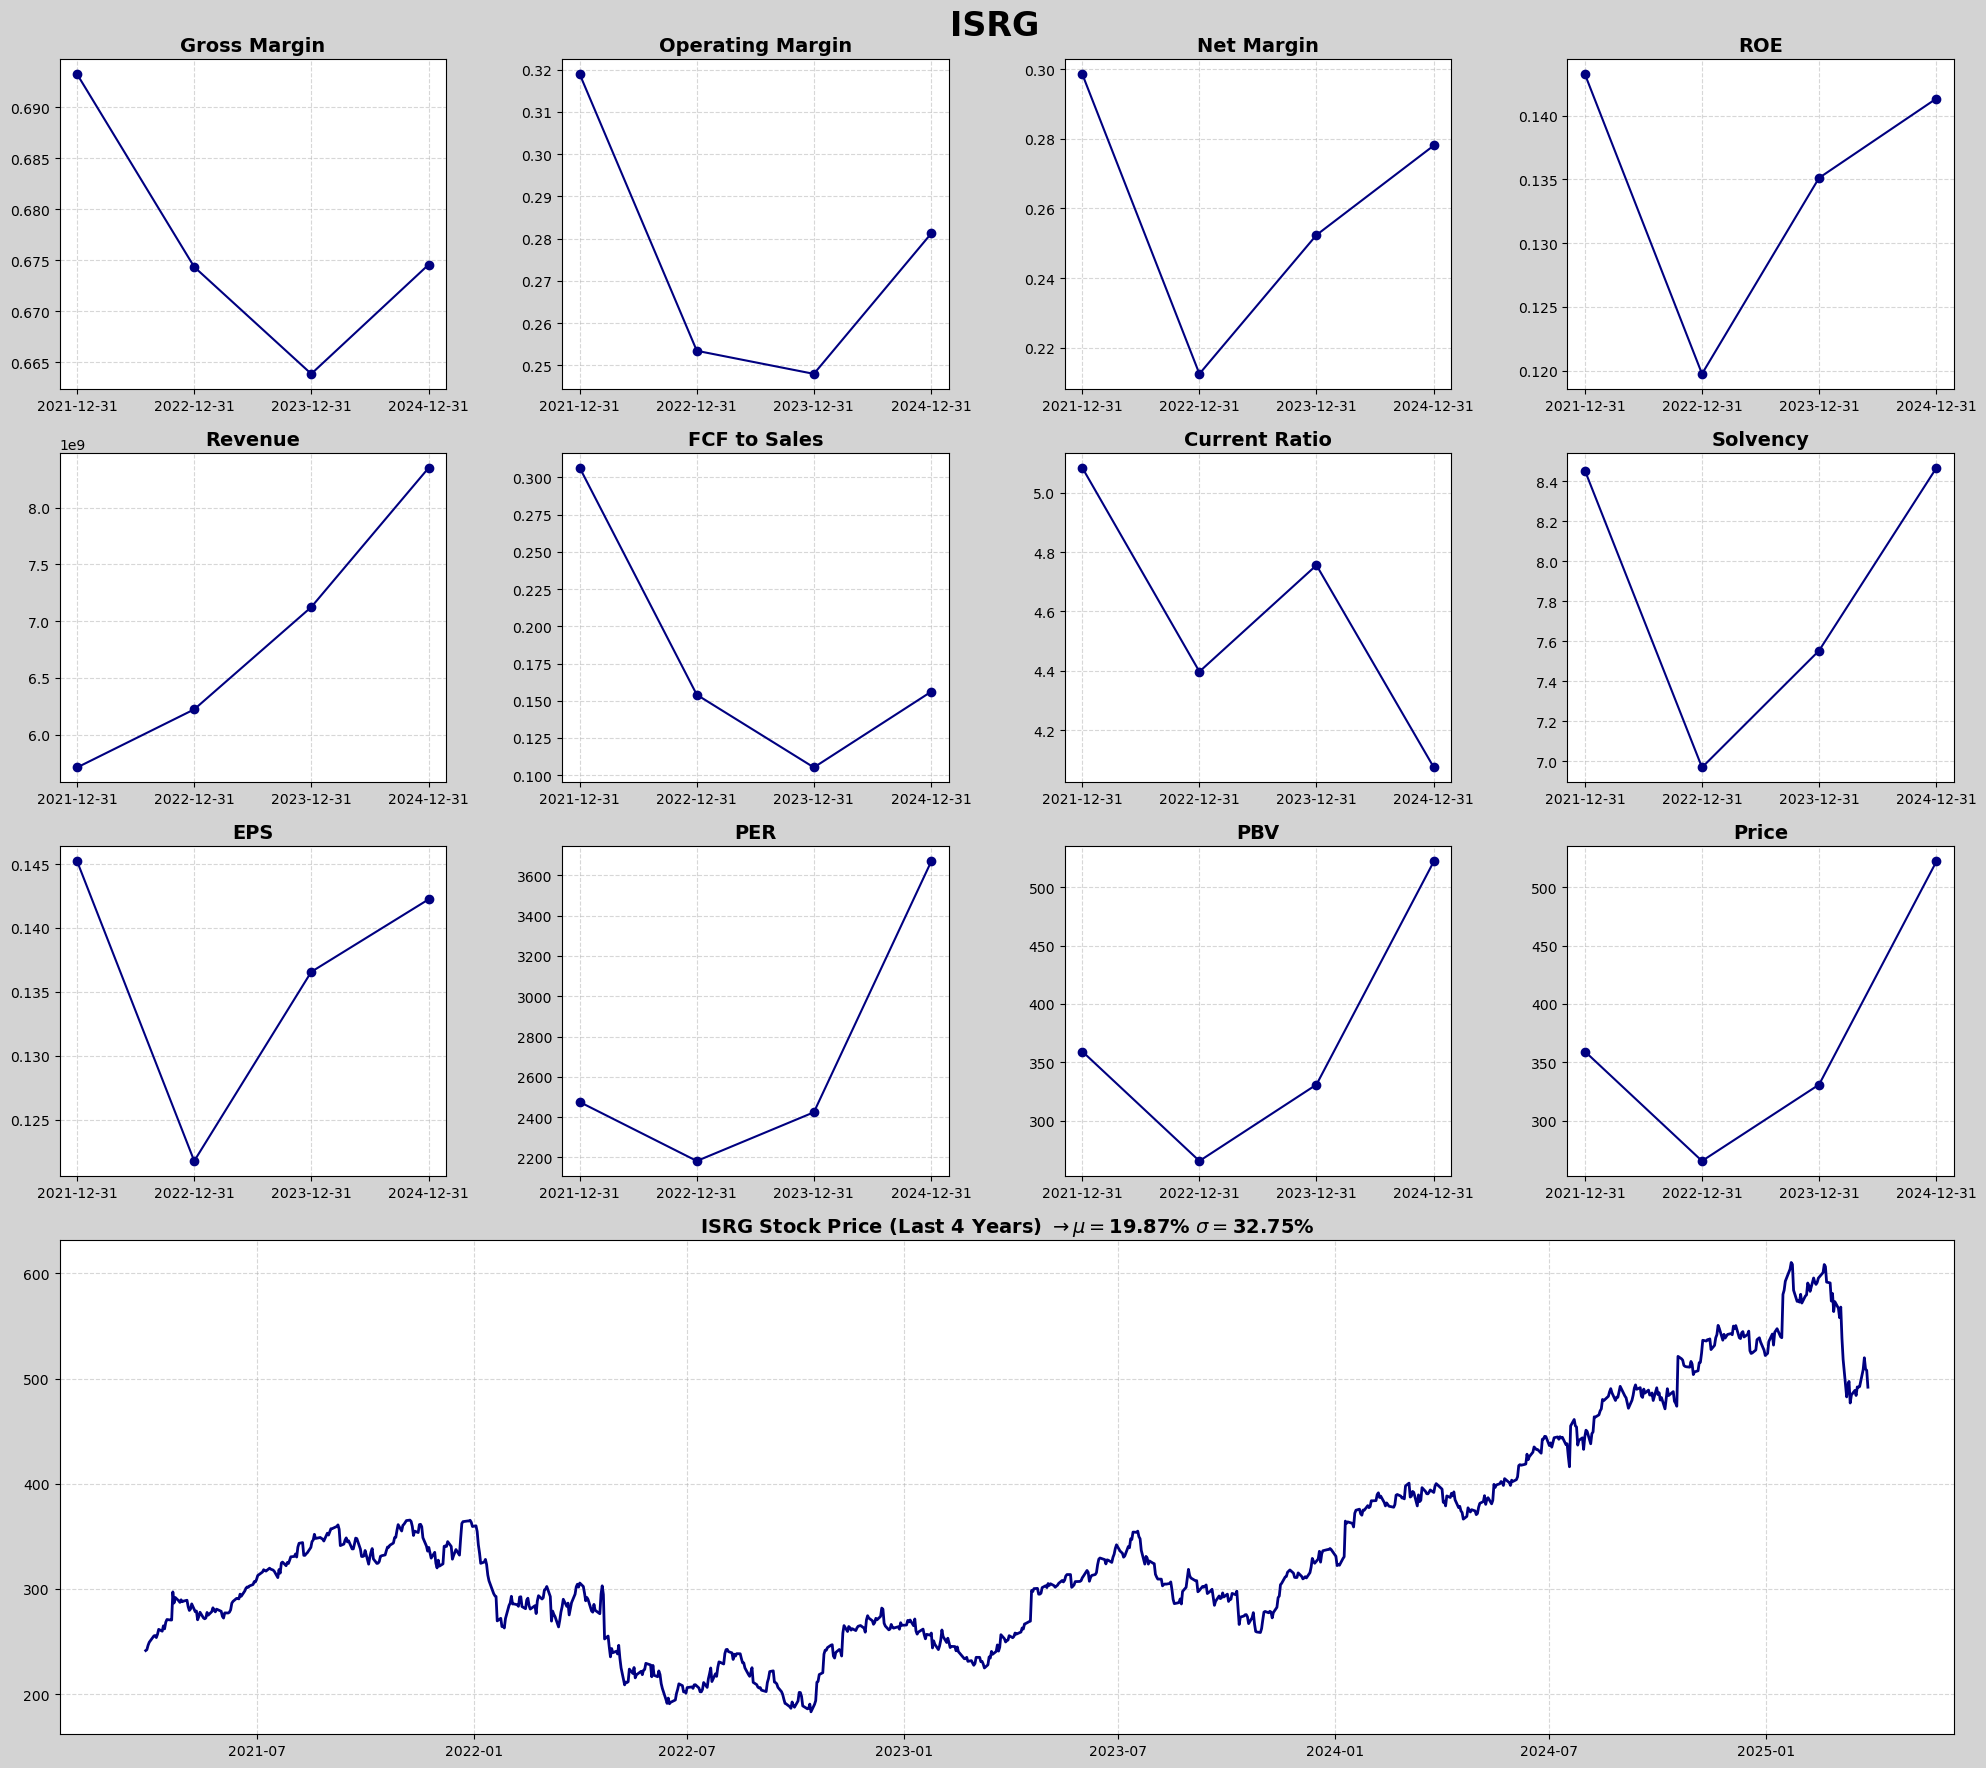

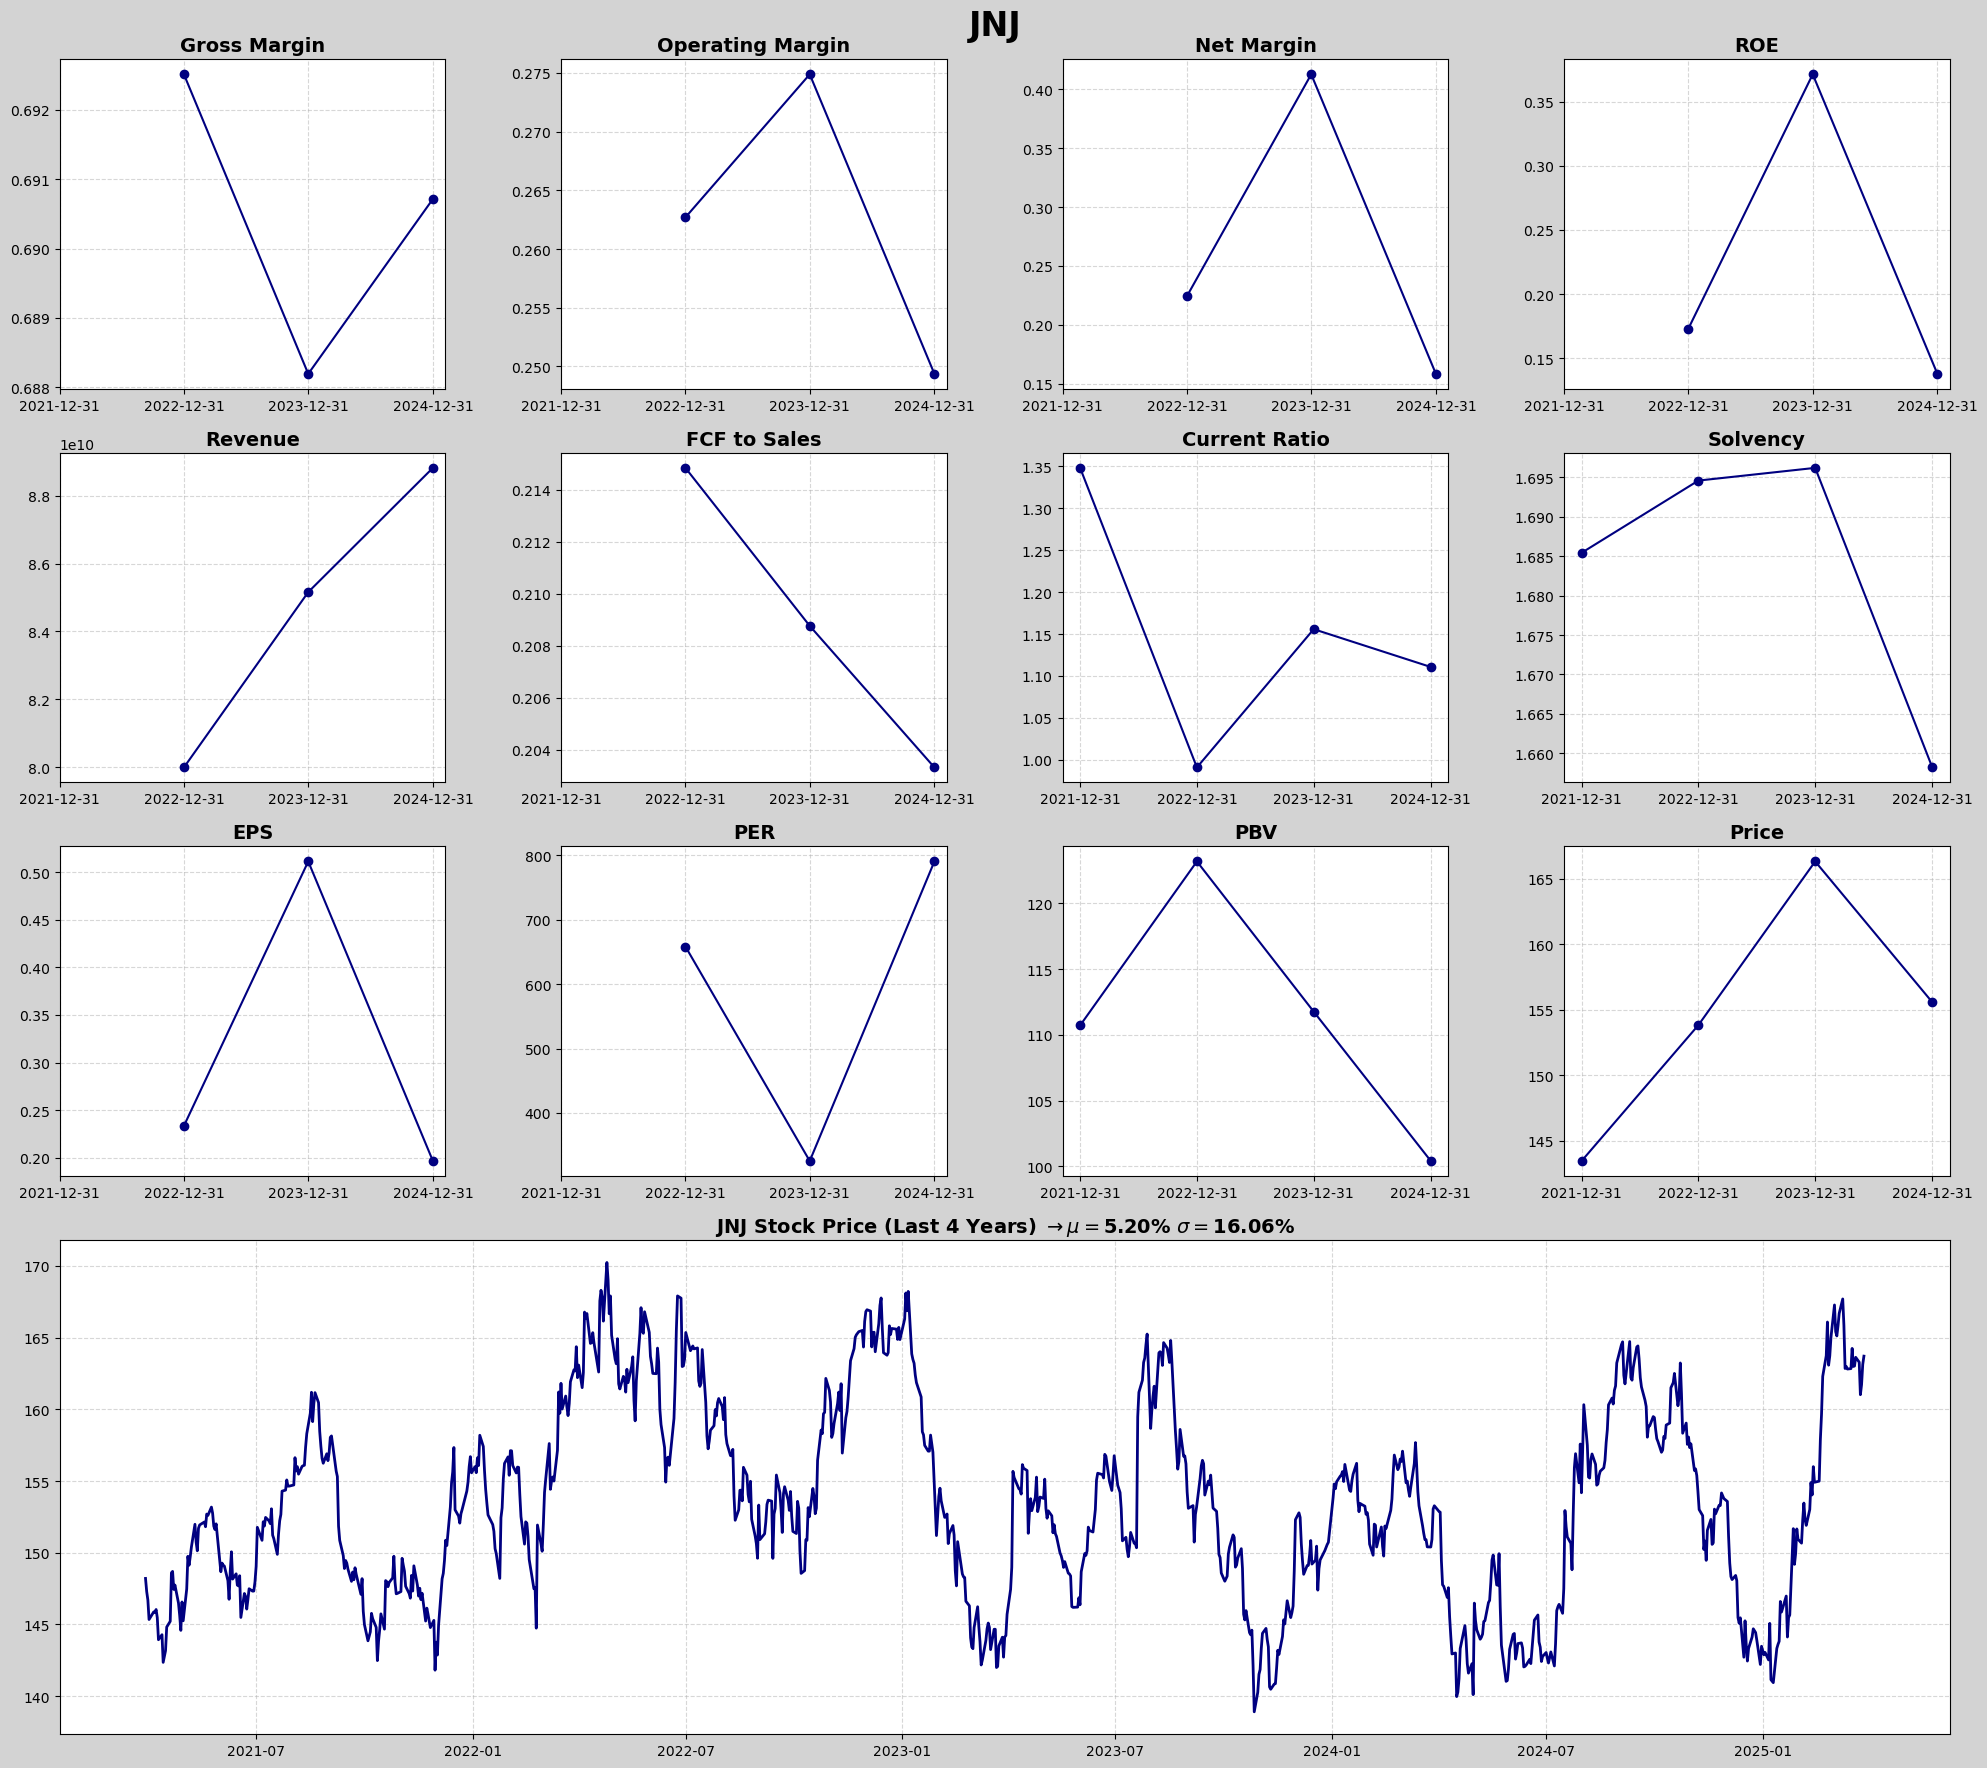

In [3]:
healthcare =  ["ISRG", "JNJ"]
for i in range(len(healthcare)):
    plot_financials(healthcare[i])

# Energia

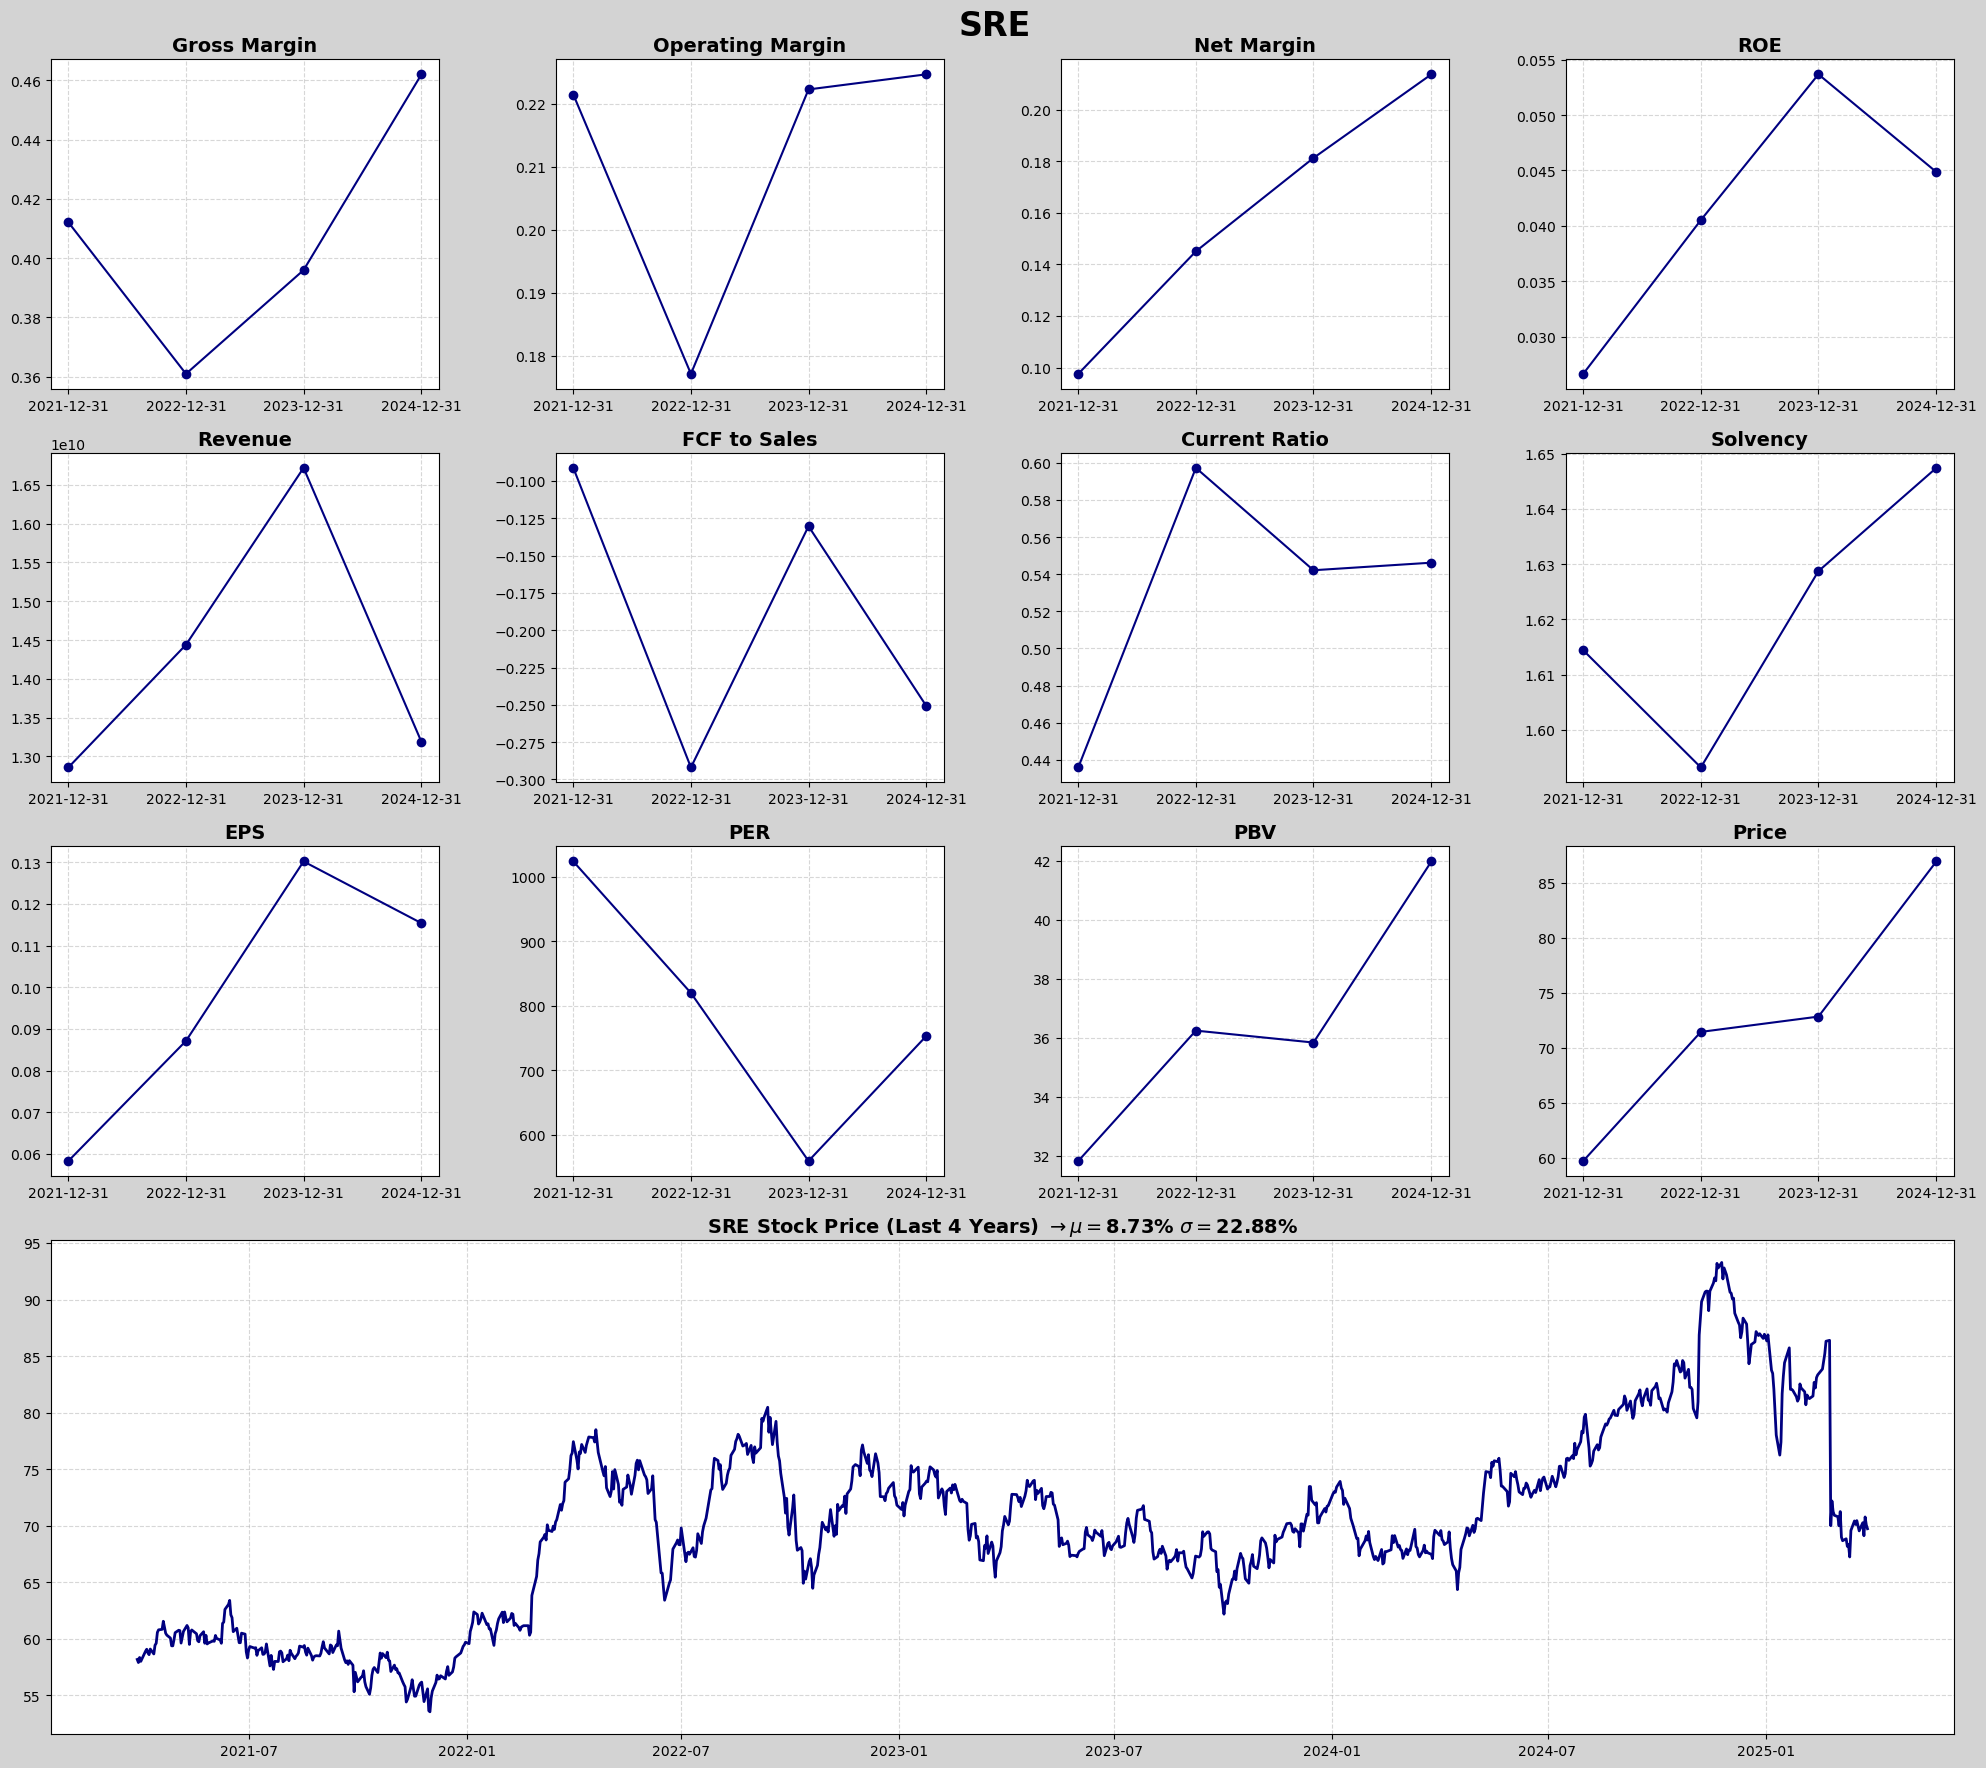

In [4]:
utilities_energy = ["SRE"]
for i in range(len(utilities_energy)):
    plot_financials(utilities_energy[i])

# Industrial

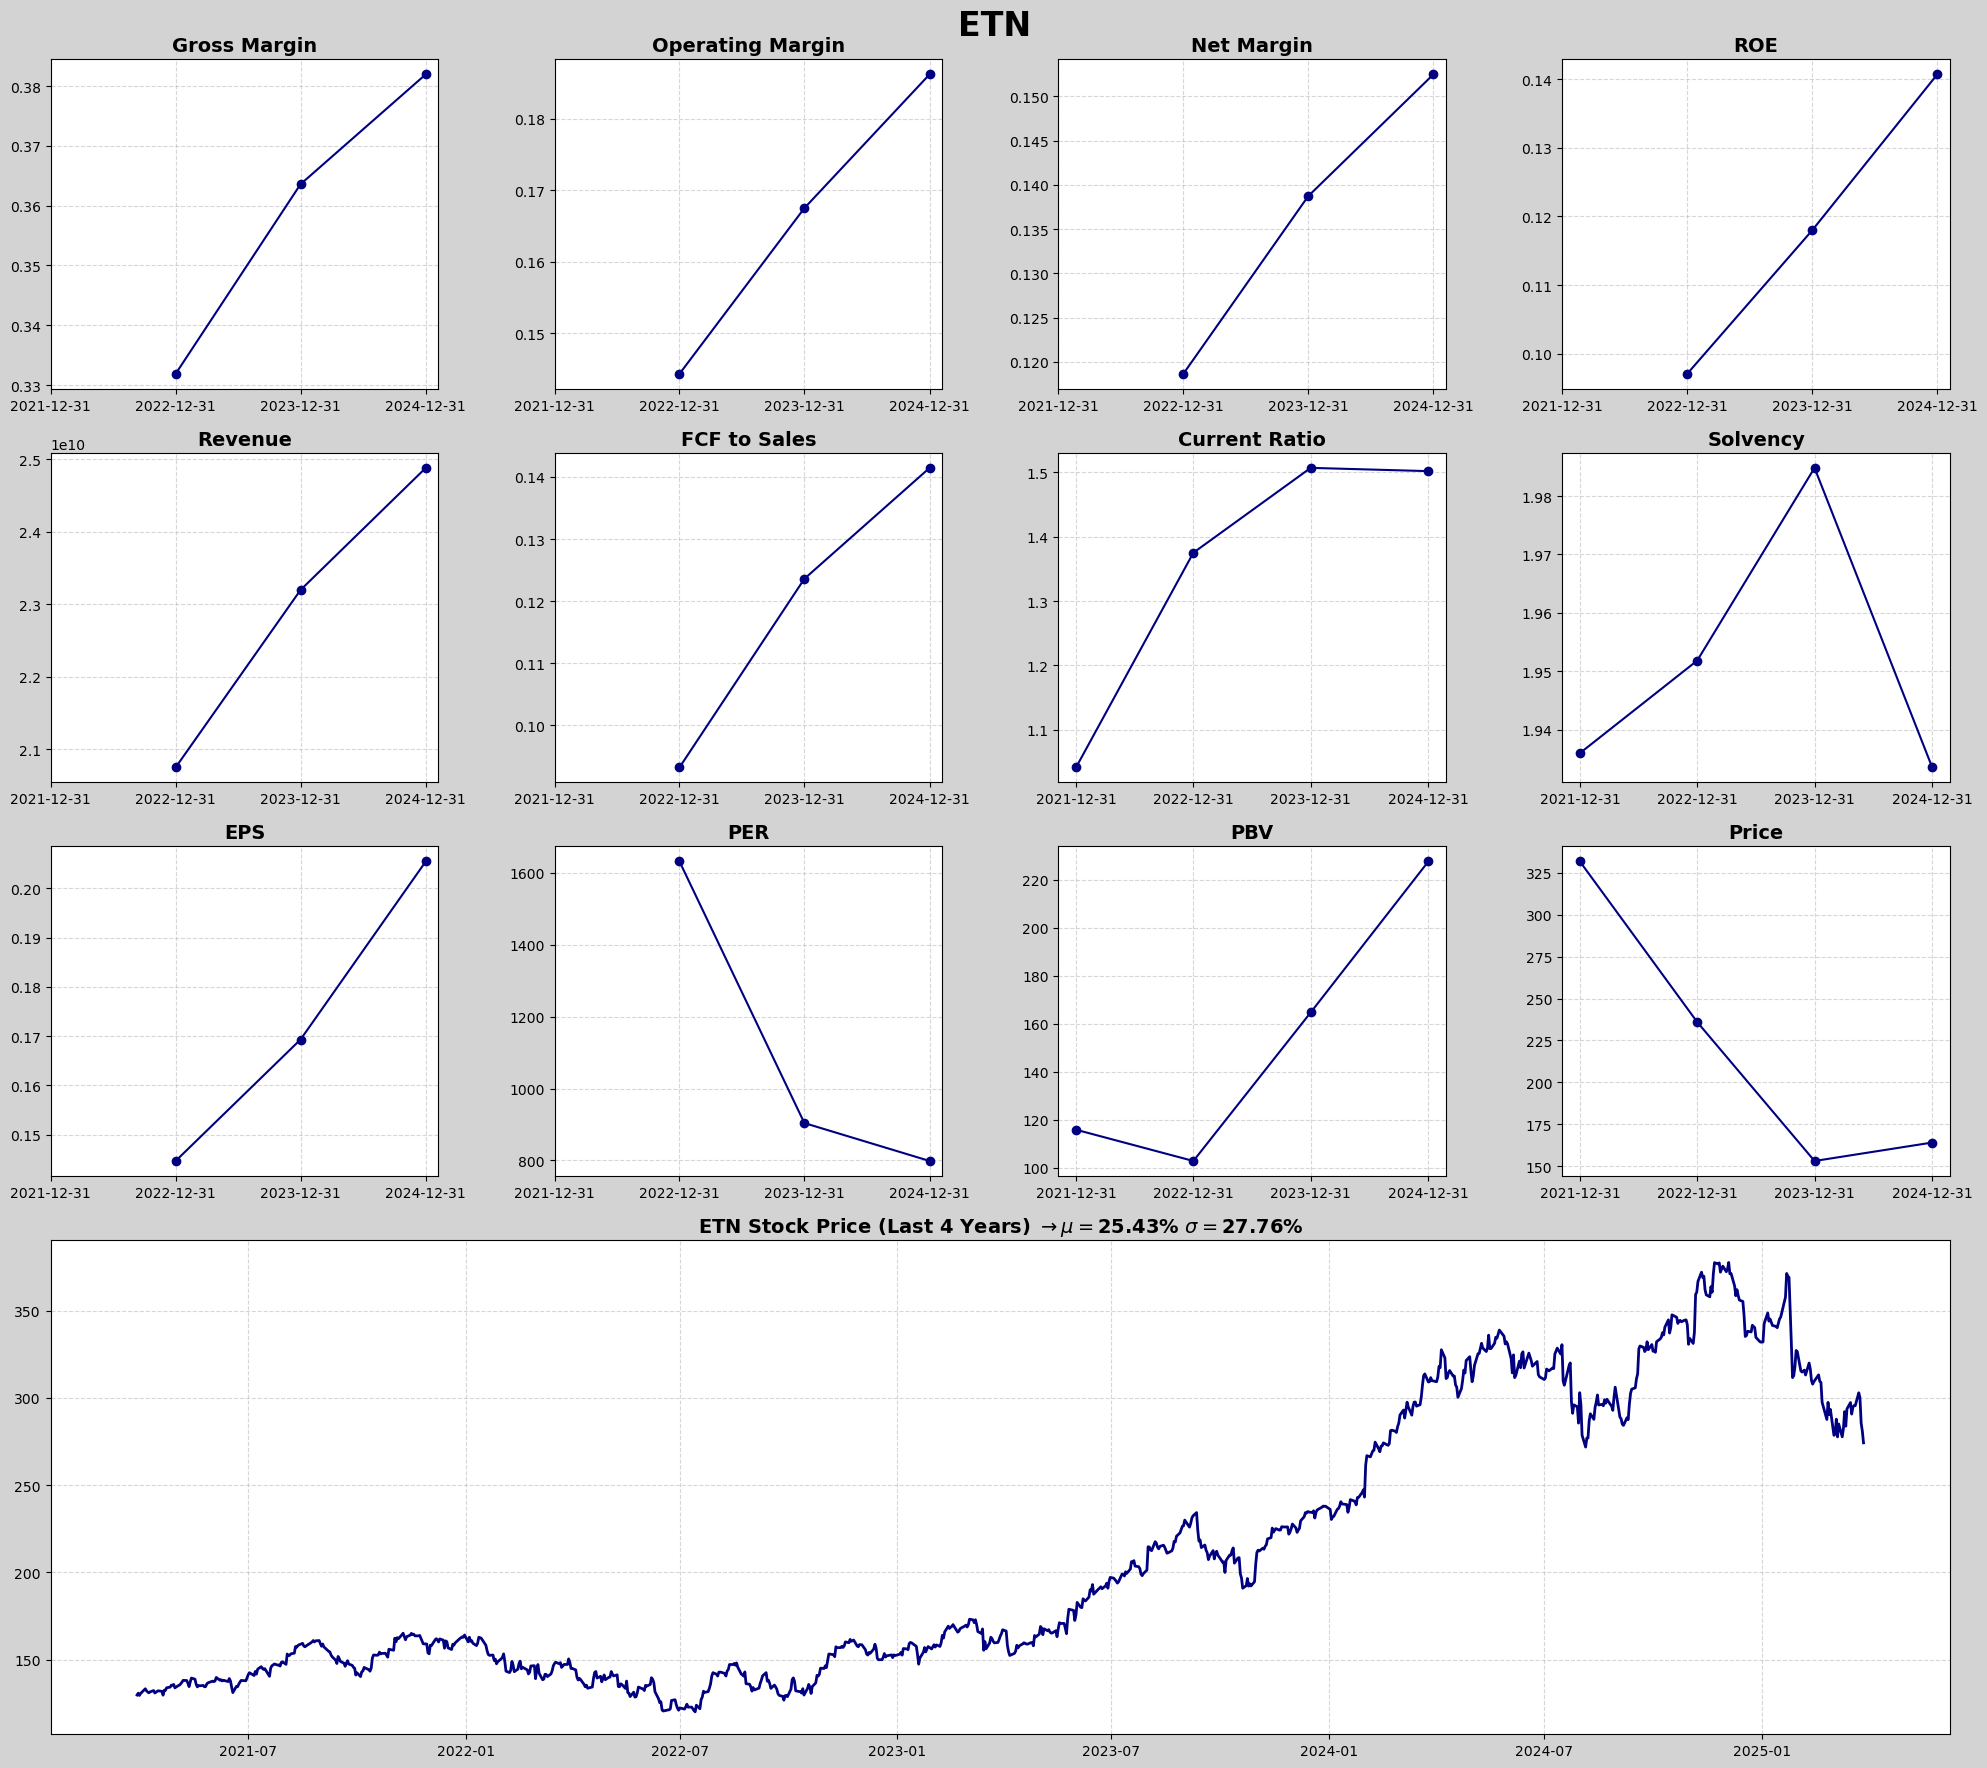

In [5]:
industrials = ["ETN"]
for i in range(len(industrials)):
    plot_financials(industrials[i])

# Bienes no escenciales (lujo)

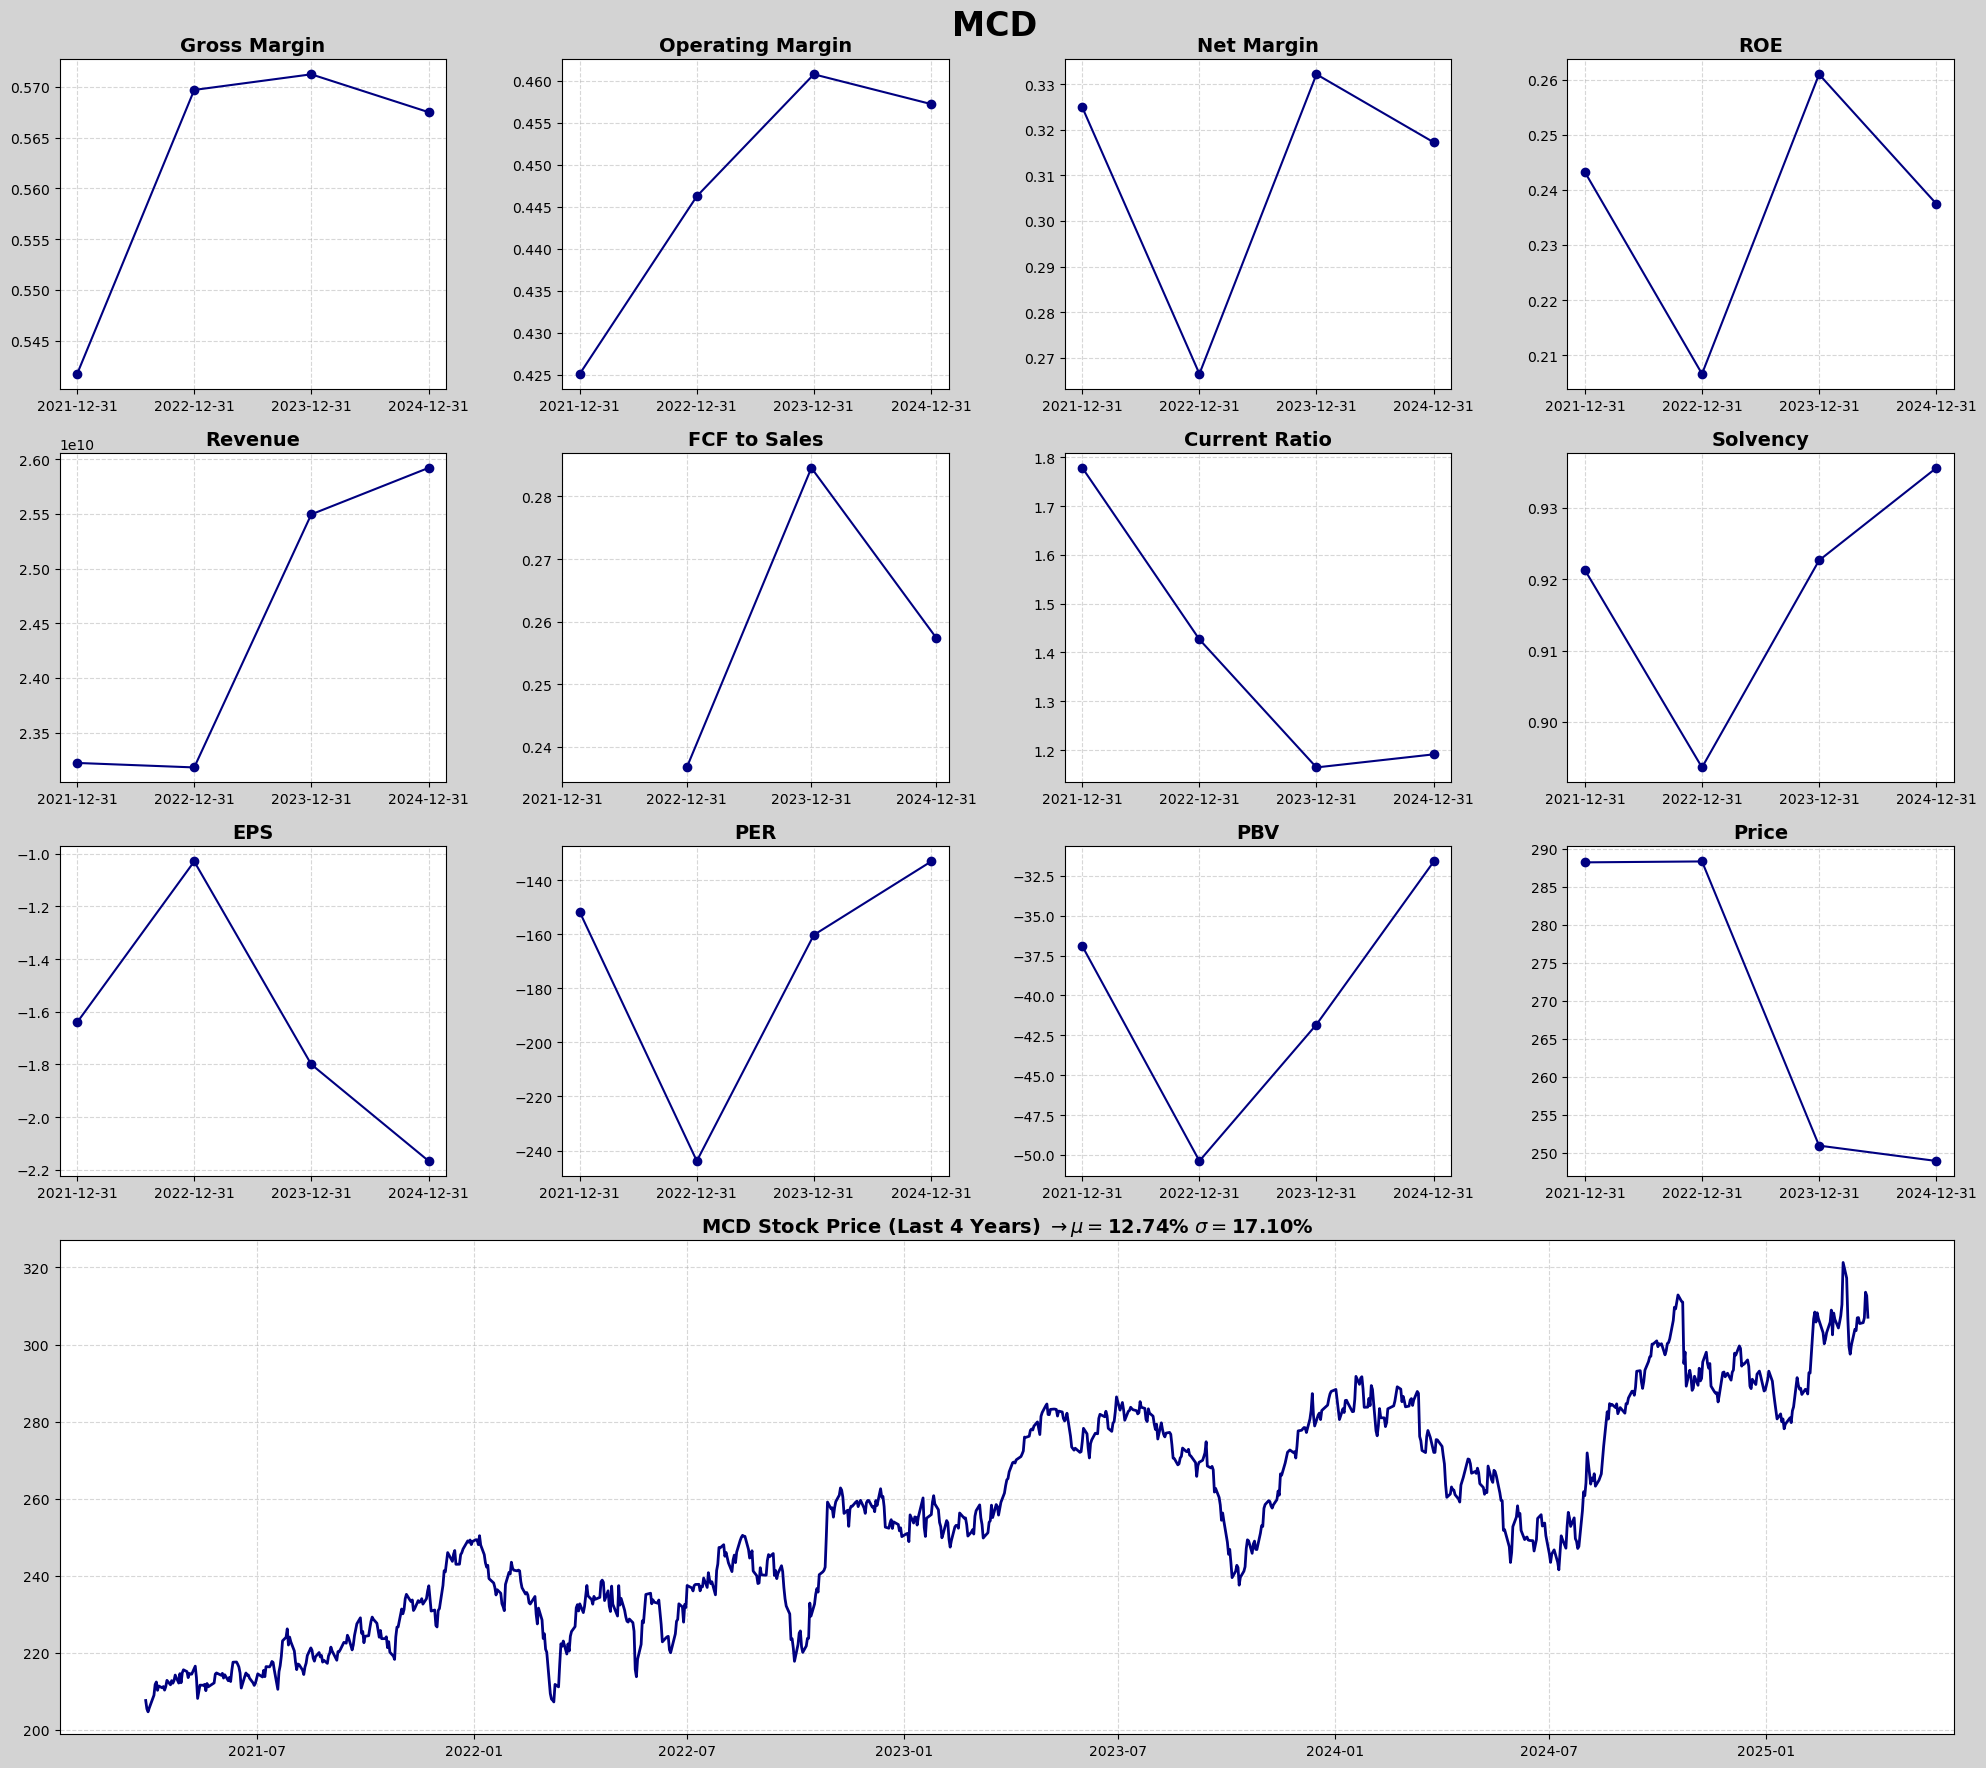

In [6]:
consumer_discretionary = ["MCD"]
for i in range(len(consumer_discretionary)):
    plot_financials(consumer_discretionary[i])

# Mercados emergentes

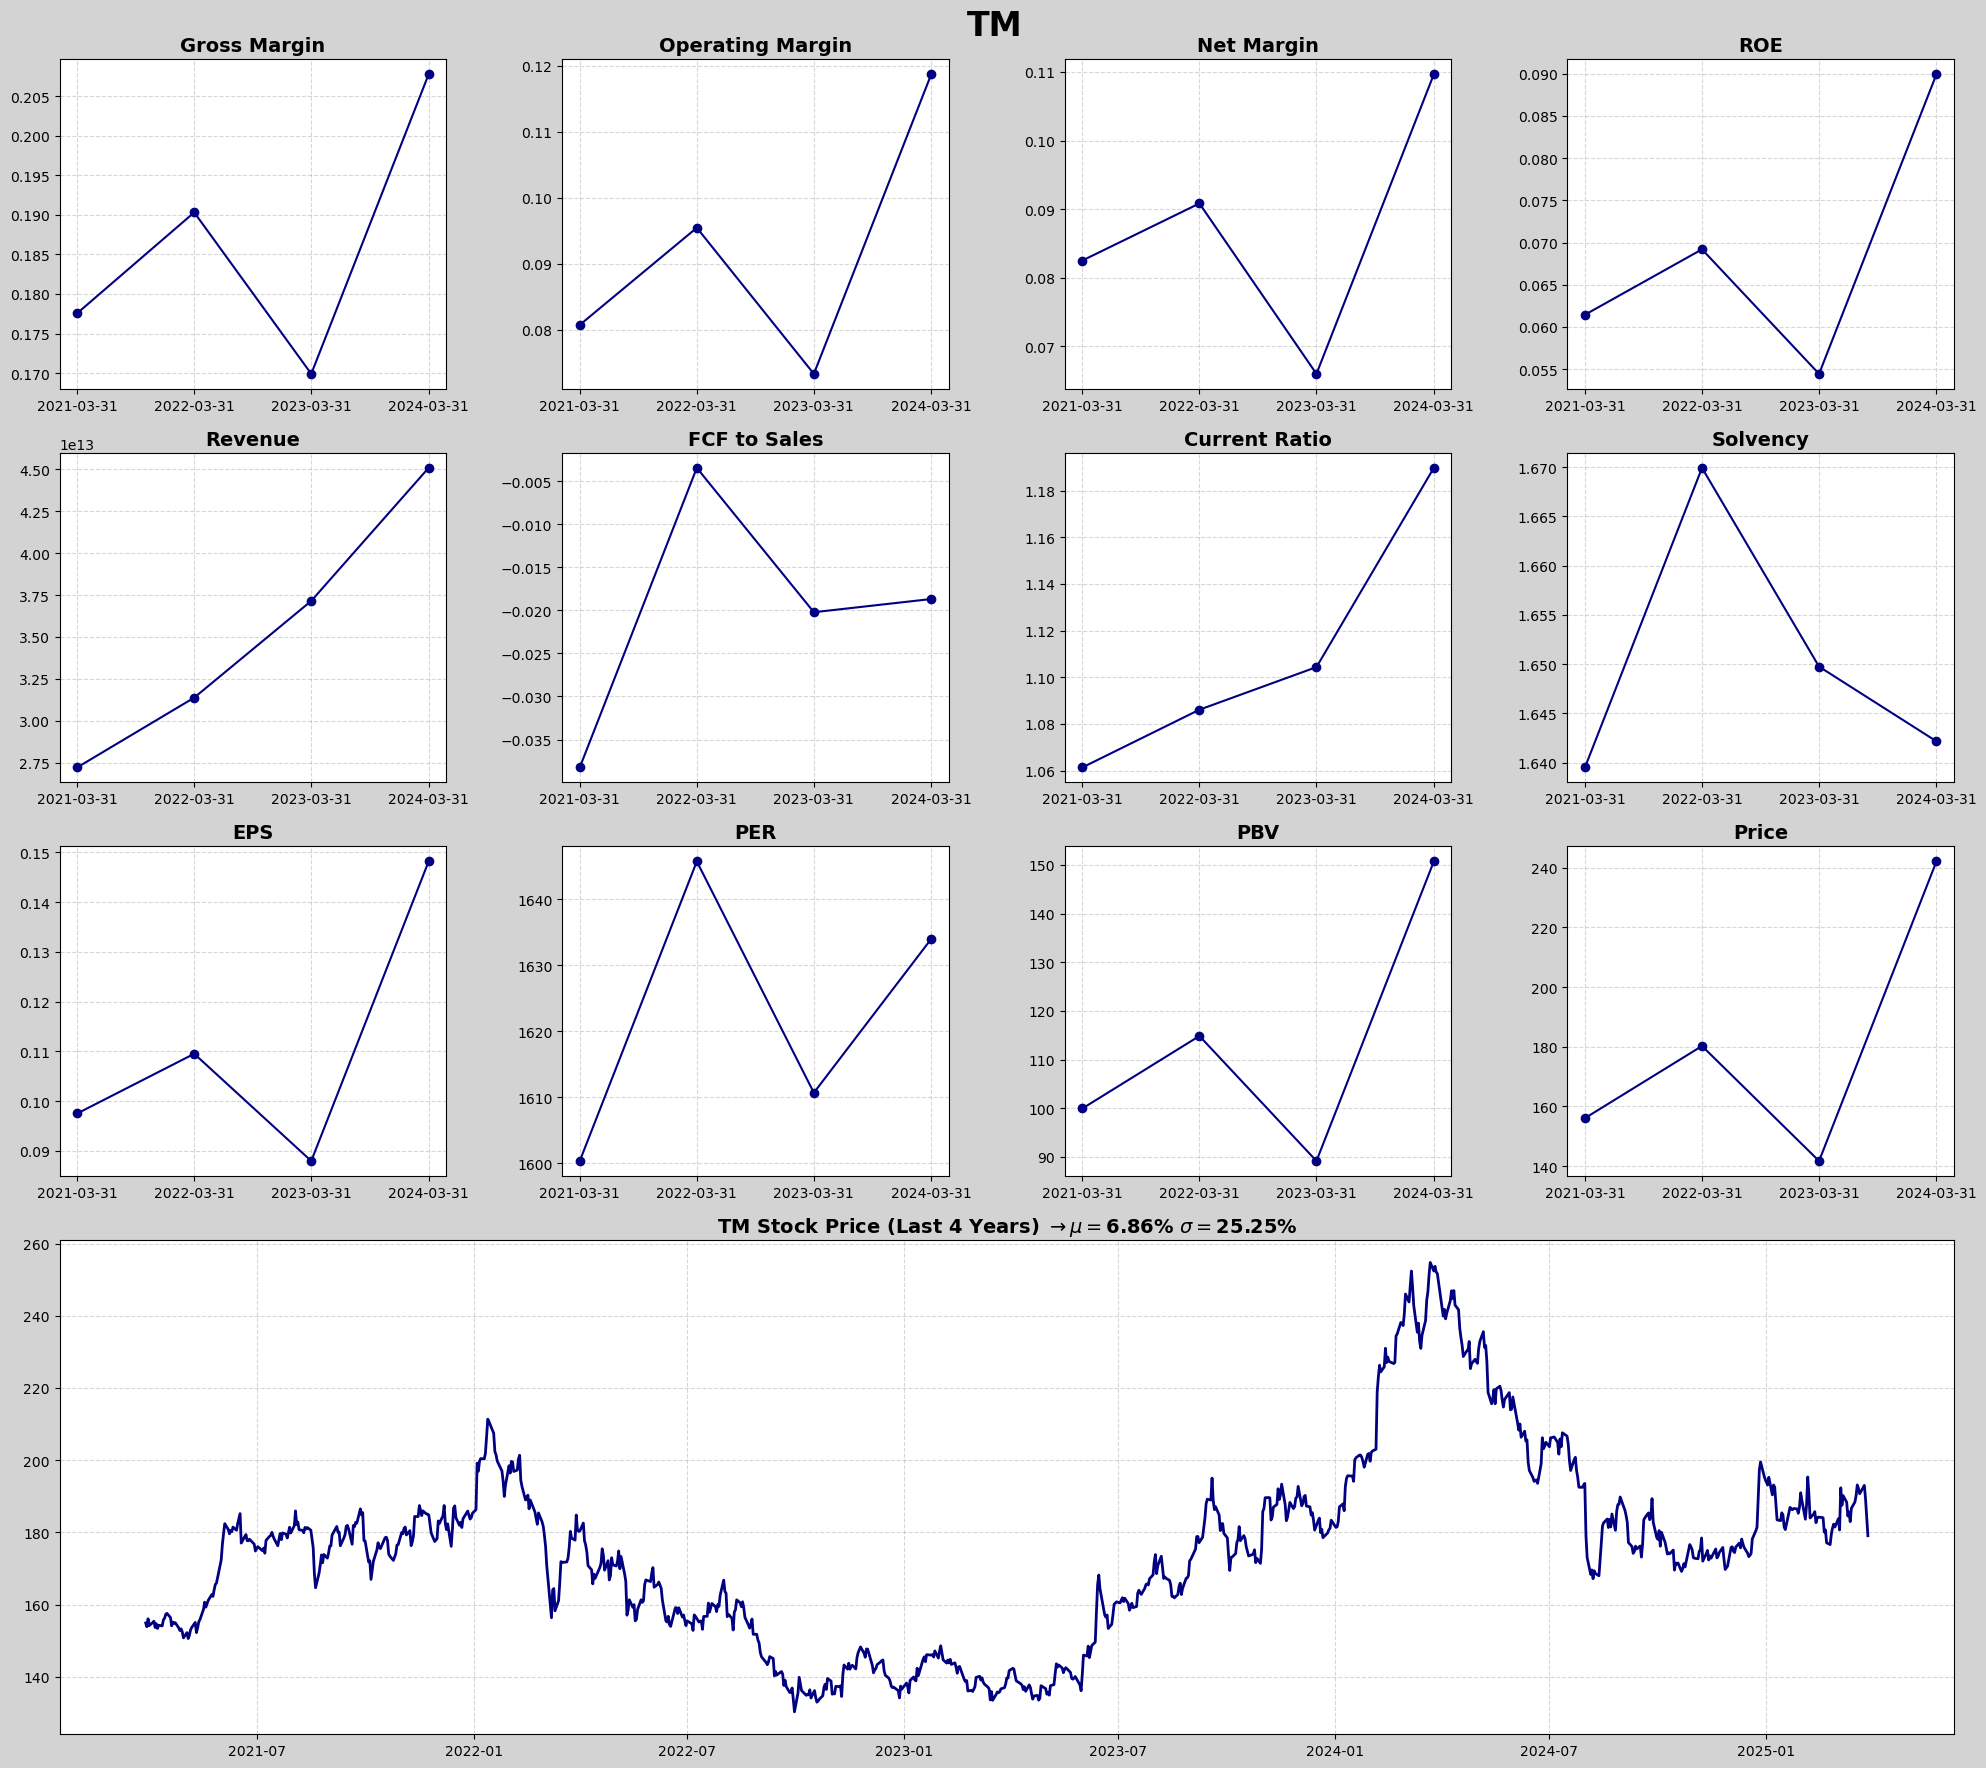

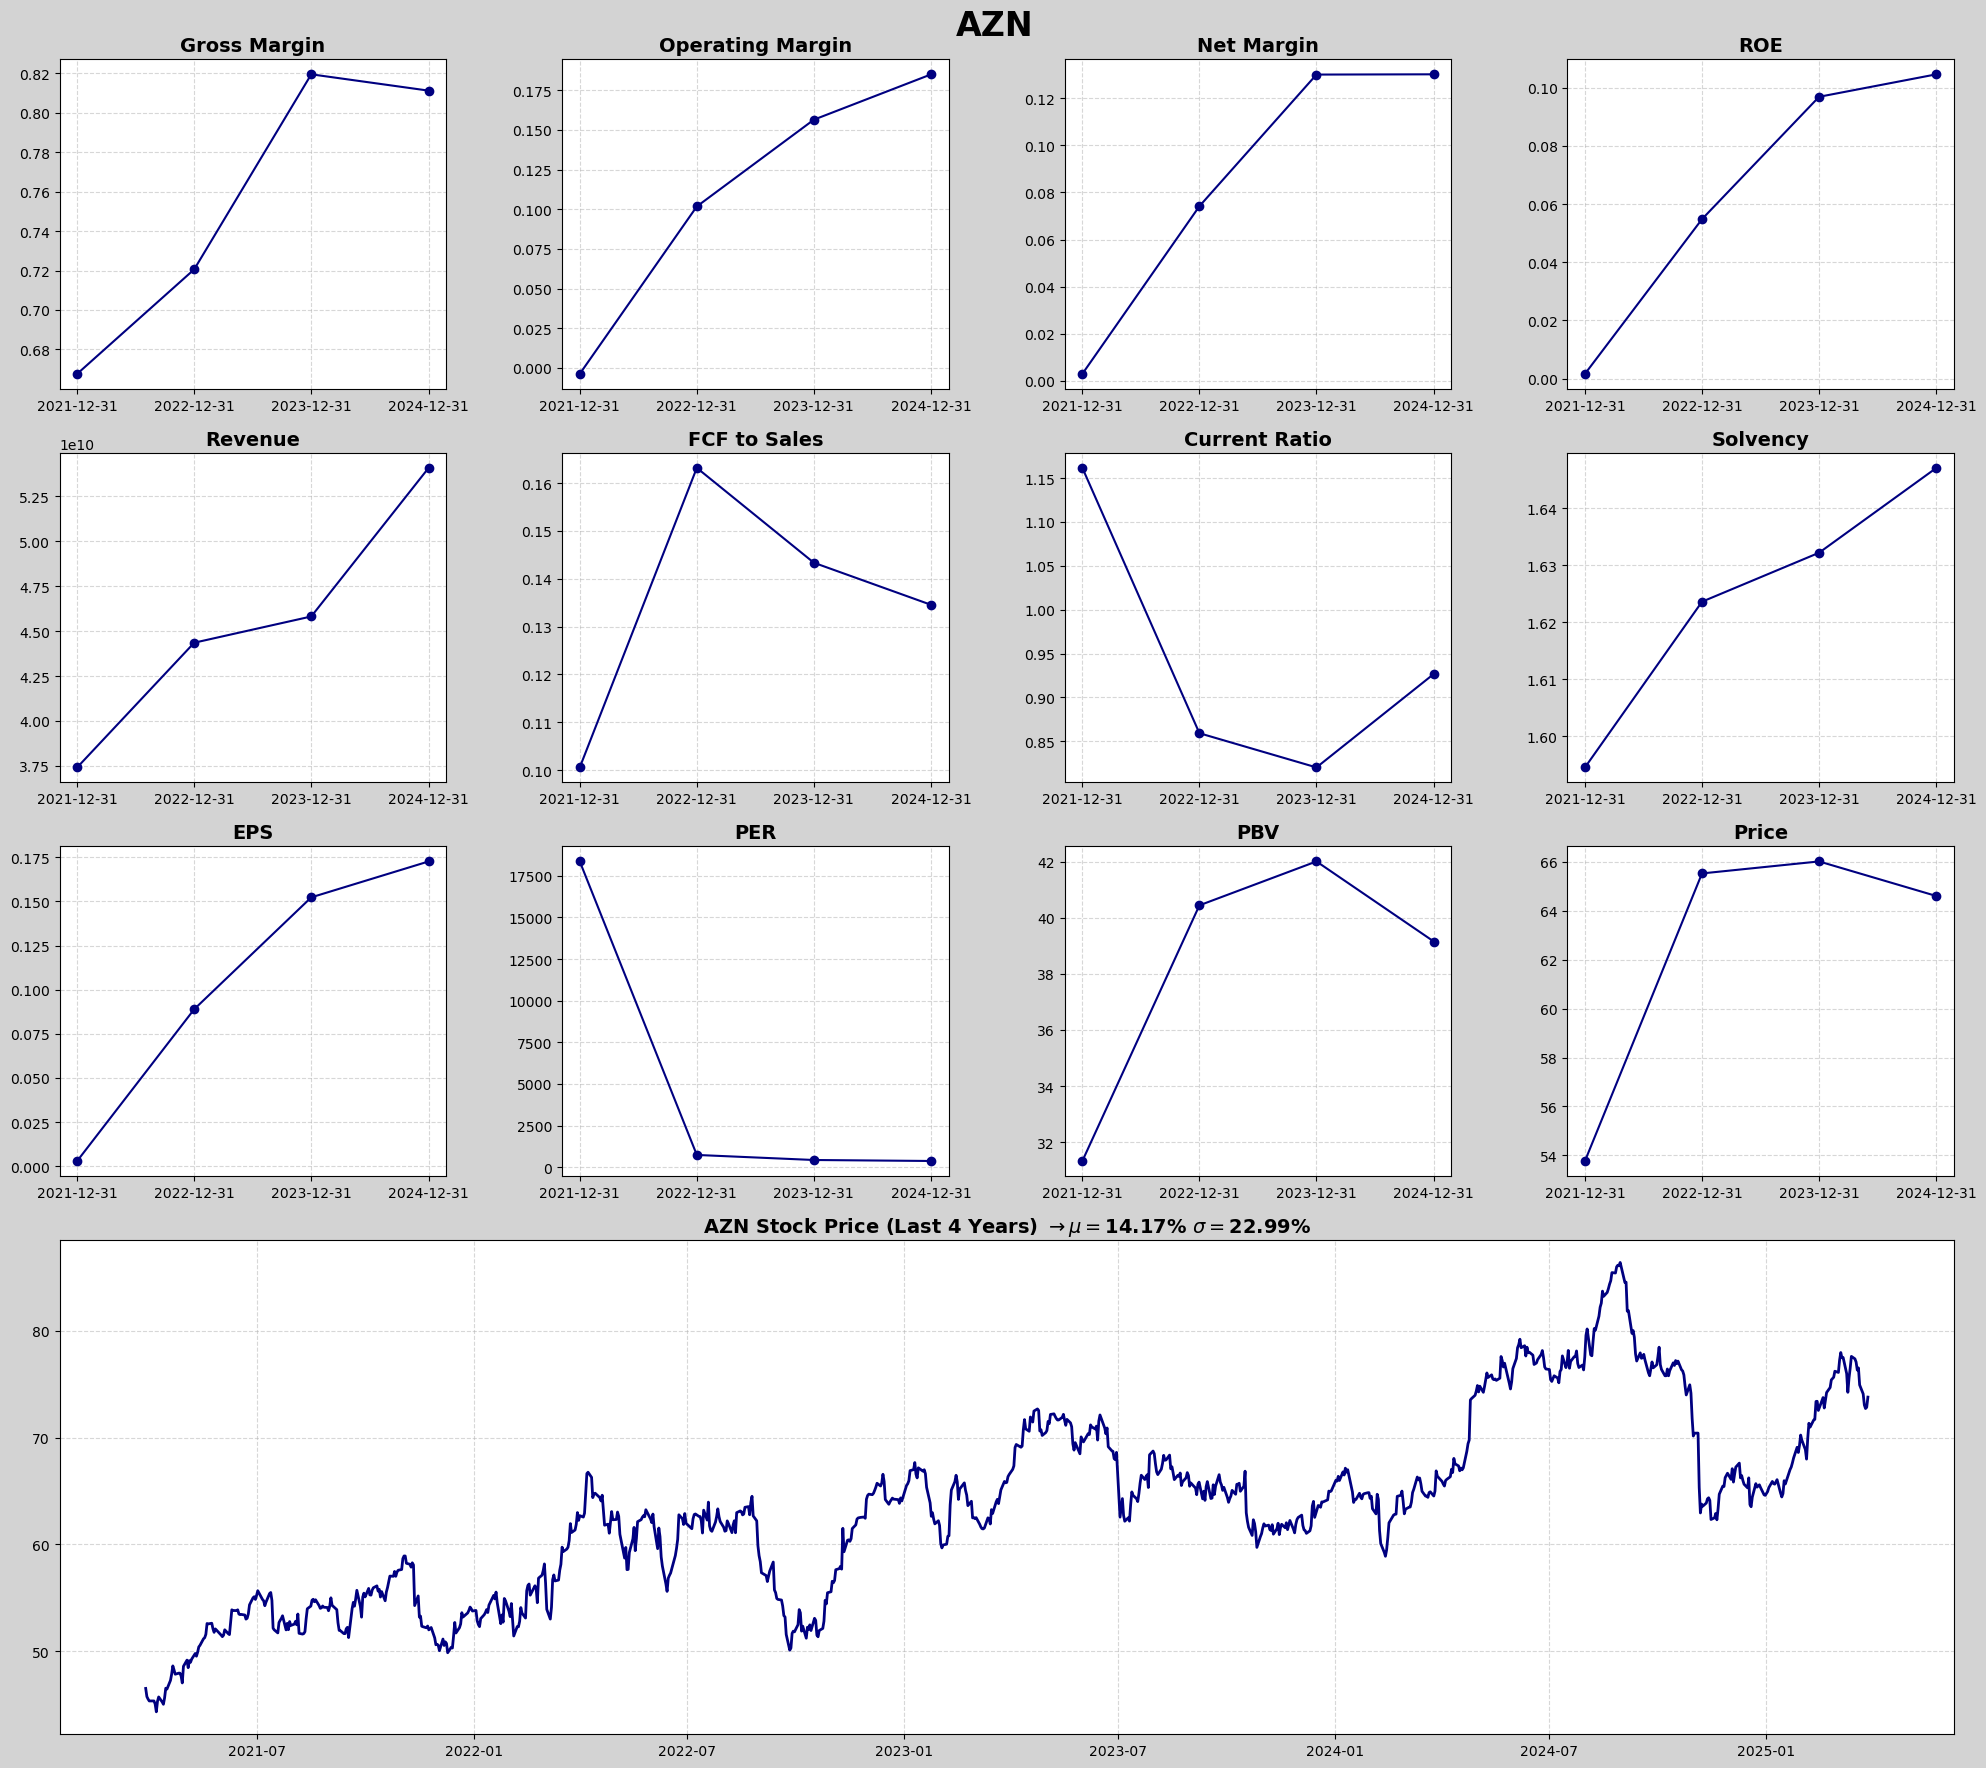

In [7]:
emerging_markets = ["TM", "AZN"]
for i in range(len(emerging_markets)):
    plot_financials(emerging_markets[i])

# Investigación activos

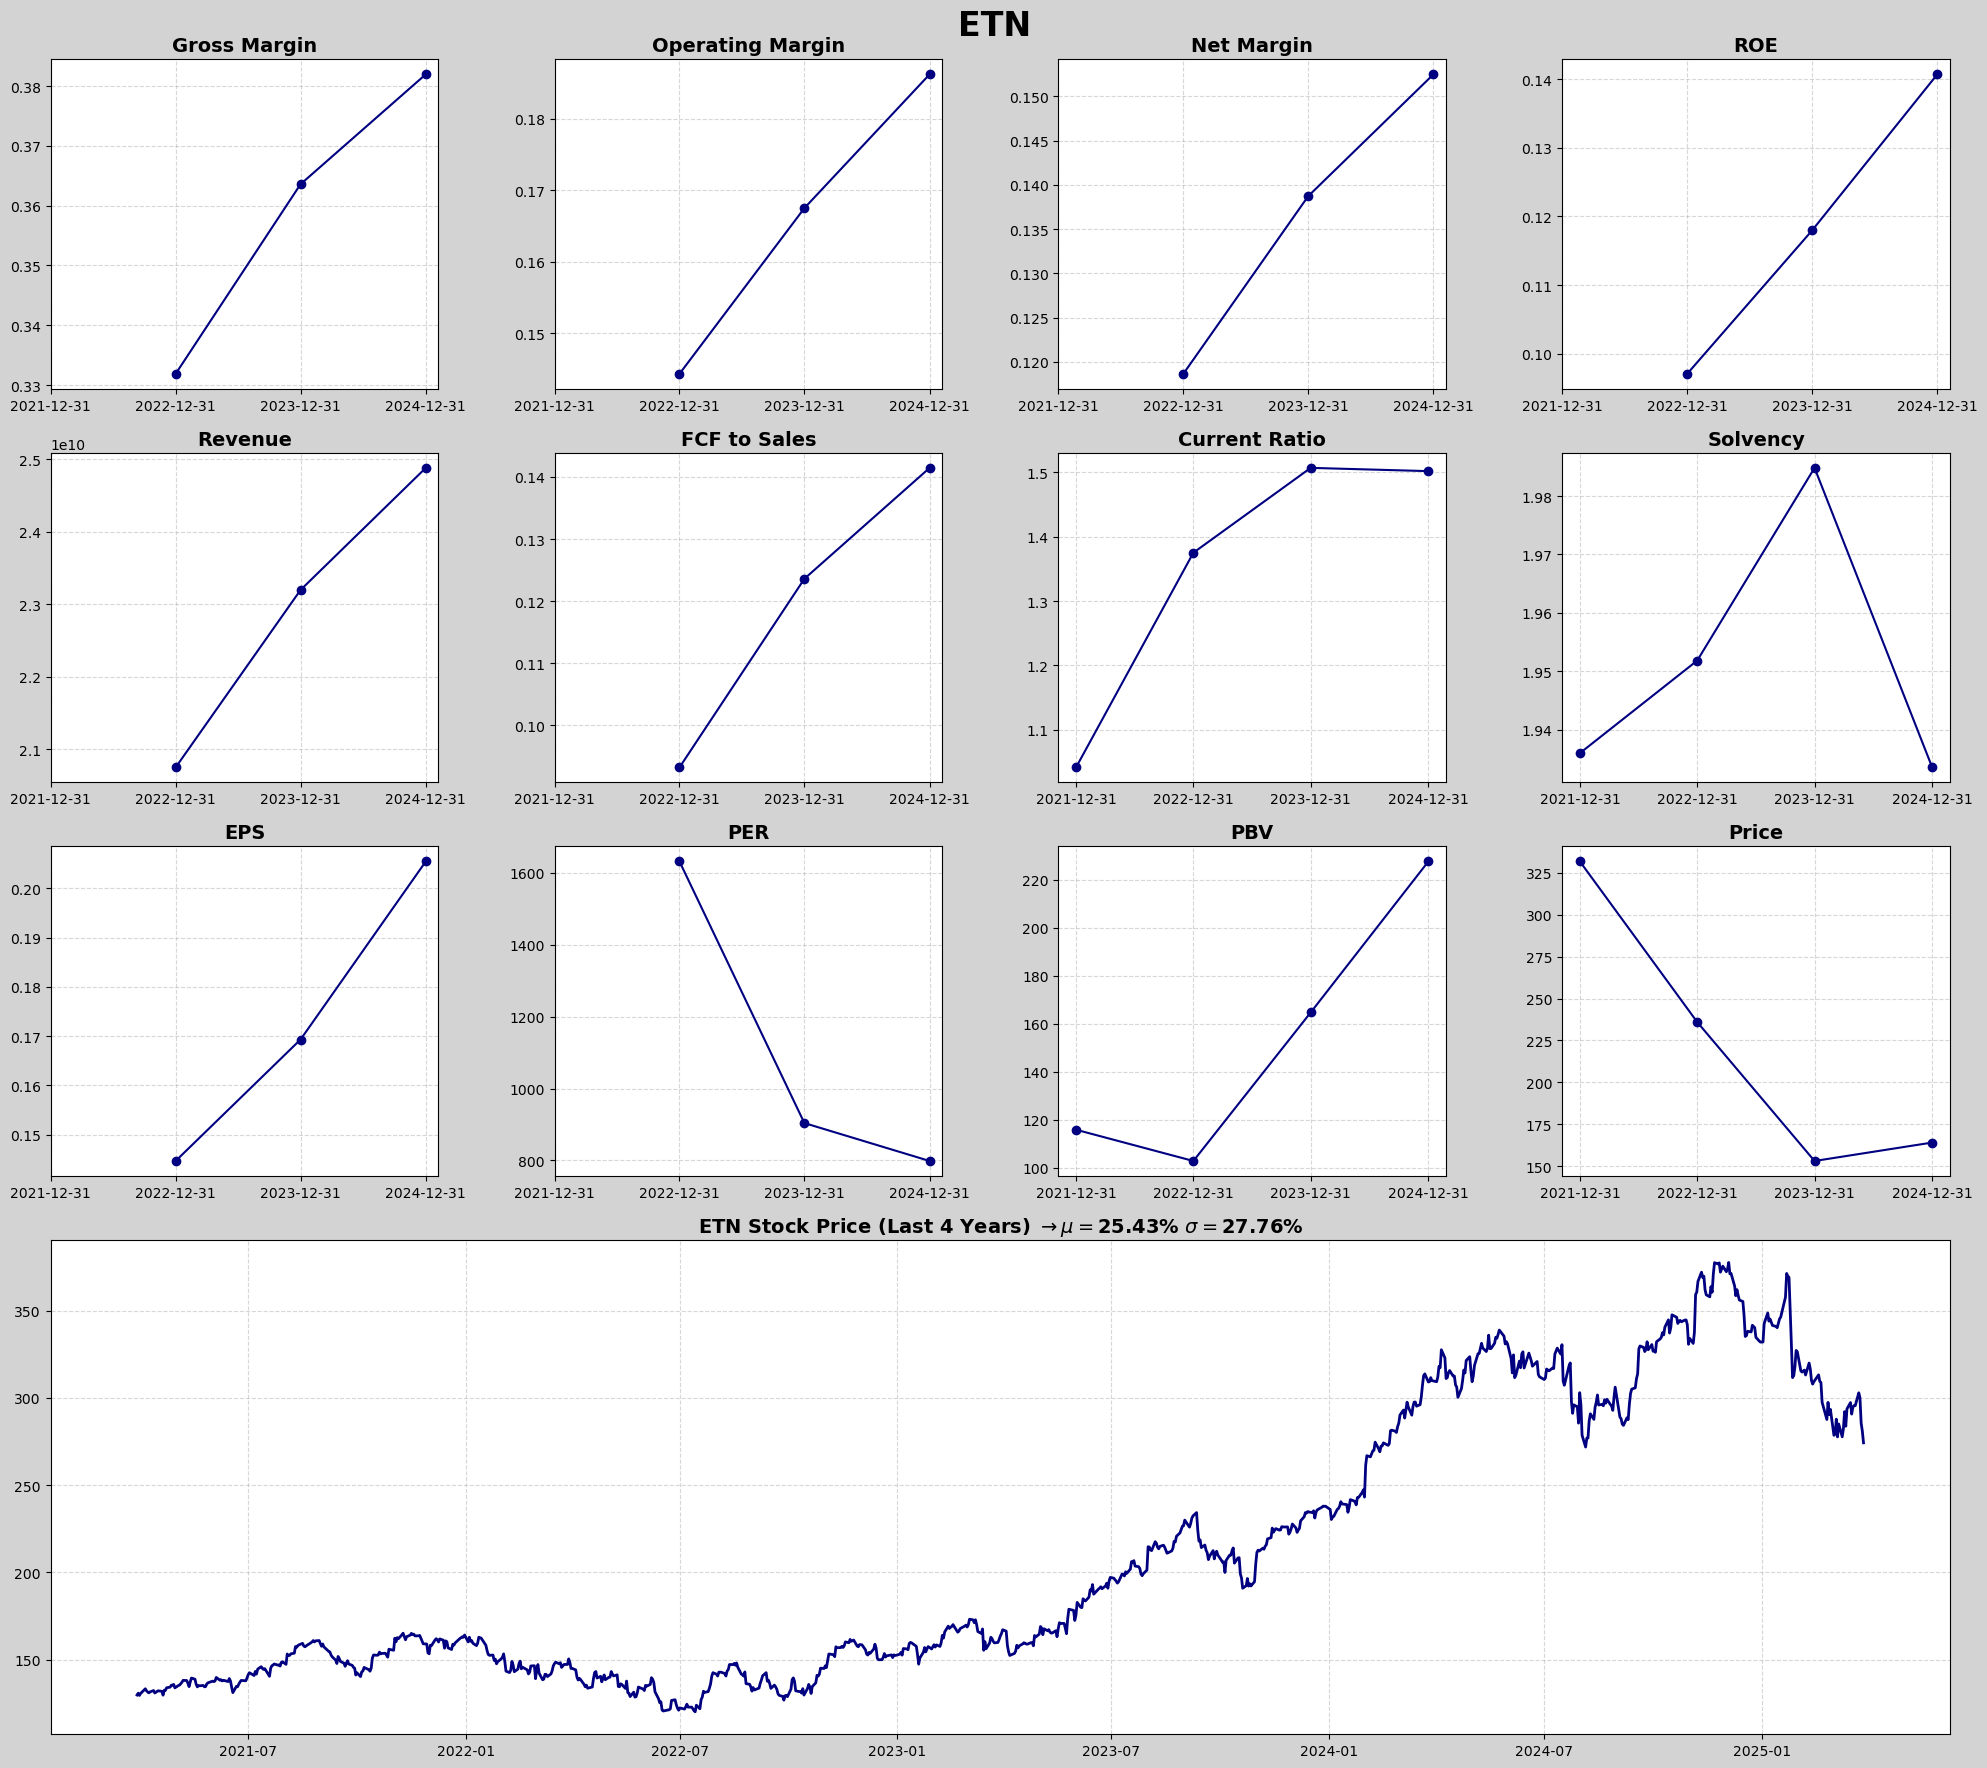

In [10]:
emerging_markets = ["ETN"]
for i in range(len(emerging_markets)):
    plot_financials(emerging_markets[i])

## <font color='royalblue'> McDonald's Corporation <font color='black'>

### <font color='dodgerblue'> Descripción de la empresa <font color='black'>
McDonald’s Corp. es una de las empresas más grandes en el mundo de la comida rápida. Fue fundada oficialmente en 1955 por Raymond Albert Kroc en San Bernardino, California, EE. UU. Actualmente, tiene su sede en Oak Brook, Illinois; sin embargo, opera a nivel nacional e internacional, con presencia en más de 100 países, siendo sus principales mercados Estados Unidos, Alemania, Reino Unido, Francia e Italia.

Principalmente, es reconocida por ser una empresa dedicada a la venta de hamburguesas; no obstante, también vende pollo en distintas presentaciones, al igual que bebidas, papas fritas, entre otros productos. El segmento de Mercados con Licencia de Desarrollo y Corporativo Internacional consiste en mercados con licenciatarios de desarrollo y afiliados dentro del sistema de McDonald’s.

Aunque su giro principal es la venta de alimentos, sus productos son considerados bienes de lujo, ya que la gente suele consumirlos cuando tiene un excedente de dinero. Este comportamiento convierte a McDonald’s en una empresa con un comportamiento cíclico.

---
### <font color='dodgerblue'> Fundamentales <font color='black'>

McDonald’s mostró recientemente un margen bruto del 56.3%, operativo del 45.8% y neto del 31.7%, los cuales se encuentran muy por encima de la media de su industria, que fue del 26.7%, 10.4% y 5.8%, respectivamente. Esto muestra la gran solidez de la empresa frente a sus competidores directos, lo cual es un muy buen indicador.

Su free cash flow se ha mostrado relativamente constante, con un margen actual del 25.7%, un valor sobresaliente respecto a la industria, cuya media se encuentra en 6.2%. Este es un muy buen margen, ya que permite a McDonald’s la oportunidad de reinvertir grandes cantidades, repartir dividendos, etc. Esto resulta atractivo para los inversores, dada su capacidad de crecimiento en el futuro.

Su liquidez no es tan fuerte, ya que cuenta con un current ratio de 1.19 y una solvencia de 0.94. Ambos valores se encuentran por debajo de los niveles deseados; sin embargo, aún logra posicionarse por encima de sus competidores, cuyos ratios medios son de 1.11 y 0.53, respectivamente.

Cuenta con un EPS de 11.39, el mayor de la industria con diferencia, lo que la muestra como la empresa más rentable para los inversionistas. Tiene un P/E de 26.96, el cual es menor a la media de la industria, situada en 48.76. Esto indica una infravaloración respecto a la industria, lo que puede ser un buen indicador con base en el resto de los fundamentales analizados.

---
### <font color='dodgerblue'> Planes a futuro <font color='black'>

A finales de 2024, la empresa compartió que espera alcanzar un total de 50,000 restaurantes en todo el mundo para 2027, lo que significa que tiene pensado abrir alrededor de 10,000 sucursales en los siguientes tres años. Se estima que el 70% de estos nuevos restaurantes estén ubicados en mercados emergentes. Países como China, India, Japón y Brasil son los principales nombres que se mencionan. En caso de lograr materializar esta meta, se estaría hablando del crecimiento más rápido de la empresa en sus casi 70 años de existencia.

---
### <font color='dodgerblue'> Coyuntura económica <font color='black'>

Dada la volatilidad esperada en el mercado estadounidense, McDonald’s es considerado un activo de defensa en la creación del portafolio, ya que es una empresa que muestra una baja reacción frente al mercado, lo que brinda estabilidad. Además, por sus planes a futuro, se espera que se vea beneficiado por el crecimiento de mercados emergentes, lugares en donde planea invertir grandes cantidades de dinero a corto y mediano plazo. Las empresas BlackRock y JPMorgan sugieren inversión en mercados emergentes, lo que se ve bien representado en McDonald’s.

## <font color='royalblue'> Microsoft Corporation <font color='black'>

### <font color='dodgerblue'> Descripción de la empresa <font color='black'>

Microsoft Corp. es una empresa dedicada al desarrollo y soporte de software, servicios, dispositivos y soluciones. La compañía fue fundada por Paul Gardner Allen y William Henry Gates III en 1975 en Albuquerque, Nuevo México, EE. UU. Actualmente, tiene su sede en Redmond, Washington, y presencia en 190 países del mundo. Cuenta con aproximadamente 228,000 empleados a nivel mundial y centros de datos en 60 regiones alrededor del mundo. Sus principales mercados son Estados Unidos, China, Alemania, Japón e India.

La empresa representa el 75.49% del mercado en la industria y es conocida por varios productos y servicios personales, entre los que se encuentran Windows, Xbox y Microsoft Edge. También cuenta con un área de productividad muy grande, en la que se incluyen productos como Microsoft Office y LinkedIn.

---
### <font color='dodgerblue'> Fundamentales <font color='black'>

En el último reporte, Microsoft mostró un margen bruto del 69.4%, operativo del 45% y neto del 35.4%, márgenes relativamente buenos comparados con la competencia, ya que, en promedio, esta muestra valores de 77.5%, 25.7% y 22%, respectivamente. Esto significa que Microsoft es mucho más eficiente en la administración de costos, lo que refleja que es una empresa consolidada.

Tiene un free cash flow (FCF) del 26.7%, un valor que ha aumentado en los últimos años, lo que indica crecimiento. Sin embargo, este sigue por debajo de la media de la industria (34.9%). Cuenta con un current ratio de 1.35, el segundo más alto en la industria, lo cual es bastante bueno. No obstante, enfrenta un problema a largo plazo, pues su solvencia es únicamente de 0.19, aunque sigue siendo mayor que la media de la industria (0.15).

De igual manera, su EPS es de 12.42, el segundo mejor de la industria. La empresa está infravalorada respecto a la industria, ya que su P/BV es de 9.3, mientras que el de la industria se encuentra en 15.5. Además, cuenta con un P/E de 30.51, menor a la media de 121.03. El conjunto de todos estos valores posiciona a Microsoft como una opción muy atractiva para los inversores.

---
### <font color='dodgerblue'> Planes a futuro <font color='black'>

Microsoft estima realizar una inversión de $80,000 mdd durante 2025 en inteligencia artificial a nivel mundial, destiando más de la mitad de este presupuesto en EE.UU. Se busca el desarrollo de una IA fiable que priorize la ciberseguridad y privacidad. Esta inversión está pensada para combatir la creciente competencia internacional y muestra el compromiso de un gigante tecnológico con el desarrolo de la IA.

Su presiendte, Brad Smith, posiciona a la IA como una tecnología de propósito general (TPG), con especial aplicación en la productividad de multiples sectores, comparable con la electricidad y los chips informáticos. Microsoft busca apoyar tanto el desarrollo de la IA pues creen puede llegar a ser comparable con el desarrollo de revoluciones industriales, generando millones de nuevos trabajos.  

---
### <font color='dodgerblue'> Coyuntura económica <font color='black'>

Según las expectativas de empresas como BlackRock y JPMorgan, se espera un gran crecimiento en todo el área de la inteligencia artificial. Dado que Microsoft planea invertir una cantidad tan grande de dinero en este sector a lo largo de 2025, se espera que tenga igualmente un gran crecimiento. Además, Microsoft tiene una inversión de miles de millones de dólares en la empresa OpenAI, dueña de uno de los modelos más reconocidos de IA a nivel internacional, GPT.

Dado que Microsoft pertenece al sector tecnológico, su implementación en el portafolio está vista como la de un activo ofensivo, pues, aunque implica más riesgo, se espera elevar el retorno general del portafolio con ella. 

## <font color='royalblue'> Eaton Corp. Plc <font color='black'>

### <font color='dodgerblue'> Descripción de la empresa <font color='black'>

Eaton Corp. es una empresa enfocada en la administración energética, que provee soluciones energéticamente eficientes para fuerzas eléctricas, hidráulicas y mecánicas. Fue fundada en 1911 en Bloomfield, Nueva Jersey, EE. UU. Actualmente, tiene su sede en Dublín, Irlanda, y opera en más de 175 países. Sus principales mercados son Estados Unidos, Canadá, China, Alemania y el Reino Unido.

Representa el 55.1% de la industria en cuanto a tamaño. Su enfoque principal está en dos grandes sectores: el aeroespacial y el automotriz. Además, cuenta con un segmento enfocado en la administración de energía tanto para vehículos dentro como fuera de la carretera. Su objetivo es el diseño, manufactura, distribución y venta de componentes eléctricos y electrónicos, y sistemas que mejoran el rendimiento en términos energéticos.

---
### <font color='dodgerblue'> Fundamentales <font color='black'>

La empresa reportó un margen bruto del 38.2%, operativo del 19.6% y neto del 15.3%. Estos valores son similares a los de la industria, cuya media se encuentra en 34.1%, 17.4% y 12.4%, respectivamente. Aunque las diferencias no son tan considerables, es importante aclarar que Eaton tiene mejores márgenes que la industria.

Su margen de FCF es de 14.1%, 0.8% mayor al de la industria. Tener este excedente es un buen indicador para los inversores, ya que significa que la empresa tiene el capital necesario para reinvertirlo en la empresa, repartir dividendos, etc., lo que generalmente significa un crecimiento a futuro de la empresa. Por otro lado, tiene buena liquidez a corto plazo, con un current ratio de 1.5 y una solvencia a largo plazo de 1.94.

Tiene el segundo EPS más alto de la industria, con un valor de $9.5. Se encuentra bien valorada, pues su P/BV es únicamente $0.1 menor a la media de la industria. Además, su P/E es de 28.86, también por debajo de la media. ETN se muestra como una opción muy sólida dada su comparación con la industria, bastante atractiva para los inversores, pues muestra grandes posibilidades de futuro crecimiento.

---
### <font color='dodgerblue'> Planes a futuro <font color='black'>

Al ser una empresa energética, Eaton busca enfocarse en ser más sostenible, con metas para 2030. Su objetivo es limitar el cambio climático y mitigar sus efectos catastróficos. Ya ha reducido en un 50% sus emisiones de carbono, pero aún trabaja para lograr que sus operaciones sean neutras en carbono. Además, busca certificar el 100% de sus sitios de manufactura como de cero desechos a vertederos y el 10% como de cero descarga de agua.

De igual manera, planea invertir alrededor de 3,000 millones de dólares en investigación y desarrollo de sostenibilidad durante los próximos 10 años. Todas estas metas se plantean con base científica, de modo que se buscan objetivos verdaderamente beneficiosos, además de alcanzables. 

---
### <font color='dodgerblue'> Coyuntura económica <font color='black'>

Esta es una buena opción, ya que muchas de las empresas más grandes del mundo se están moviendo para implementar energías renovables en sus procesos, lo cual beneficia a los procesos industriales de Eaton. De igual manera, se sabe que los gobiernos comienzan a implementar medidas que impulsan la adopción de energías renovables.

Aunque esta empresa es cíclica, se ve beneficiada en el largo plazo por megatendencias como la automatización. Al ser una empresa energética, también se beneficia de la transición hacia energías renovables a nivel mundial, el gasto público en infraestructura y la electrificación. 

## <font color='royalblue'> Intuitive Surgical, Inc. <font color='black'>

### <font color='dodgerblue'> Descripción de la empresa <font color='black'>

Intuitive Surgical (ISRG) se dedica a ofrecer soluciones quirúrgicas asistidas por robots y atención mínimamente invasiva a través de un ecosistema integral de productos y servicios. Fue fundada por Frederic H. Moll, John Gordon Freund y Robert G. Younge en 1995 en Mountain View, California, EE. UU. Actualmente, tiene su sede en Sunnyvale, California. Sus principales mercados son Estados Unidos, China, Alemania, Japón e India.

Cuenta con una gran participación de mercado (99.21%) respecto a la industria. Su principal producto es Da Vinci, un robot controlado manualmente, capaz de realizar todo tipo de cirugías con extrema precisión. También cuenta con Ion Endoluminal, un sistema enfocado en la implementación de catéteres y herramientas endoscópicas en las vías pulmonares. 

---
### <font color='dodgerblue'> Fundamentales <font color='black'>

En los últimos informes presentaron un margen bruto del 67.5%, operativo del 28.1% y neto del 27.8%. Todos estos márgenes son mayores a los de la mediana de la industria los cuales son de 54.1%, 17.4% y 13.8% respectivamente. Es interesante recalcar como el margen neto de ISRG es más de 2 veces el de la industria, lo que significa que son mucho más rentables. 

Tienen un margen de FCF del 15.6%, posicionandose justamente en la mediana. En cuanto a la liquidez cuentan con una seguridad enorme pues su current ratio es de 4.07, claramente el más alto en la industria y su solvencia es de 8.4, indicando que tanto a corto como a largo plazo cuentan con los recursos necesario para responder a sus obligaciones. 

Son la empresa con EPS más alto (6.42). Aunque representen casi el 100% del mercado no estan sobrevalorados pues su P/BV es de únicamente 13.67, mientras que el de la industria es de 27.25. Su P/E es elevado (76.66), posicionandose como el más alto de la industria, lo que se debe probablemente a la excectativas de crecimineto de los inversionistas en el futuro.

---
### <font color='dodgerblue'> Planes a futuro <font color='black'>

Reciente fue anunciada la noticia de que pretenden contar con presencia directa en Italia, España, Portugal, Malta y San Marino y territorios asociados, a través de la adquisición de las empresas distribuidoras de los sistemas da Vinci e Ion en estos países. Aunque ya se ha firmado el acuerdo para proceder con esta adquisición, no se espera su aprobación regulatoria hasta 2026. Tras el cierre del acuerdo en 2026, los negocios da Vinci e Ion de ab medica, Abex y Excelencia Robótica se convertirán en propiedad exclusiva de ISRG, y las operaciones comerciales se integrarán en la organización comercial y de marketing europea de ISRG.

---
### <font color='dodgerblue'> Coyuntura económica <font color='black'>

Aunque pertenece al sector médico, ISRG, es considerada como un activo ofensivo en el portafolio, pues depende mucho de la parte tecnológica. Se cree que la implementación de este activo es clave, pues es a la vez una representación de l sector salud y el sector tecnológico, ambos esperados a tenber un gran crecimiento en los proximos años. 

La demanda de los productos y servivios del sector salud son resistentes a recesiones, lo que representa una gran oportunidad de crecimiento para ISRG. Las cirujías asistidas roboticamente han aumentdo considerablemente en los últimos años, especialmente en países con concentración de mayor edad en su poiblación como Estados Unidos, Europa y China. 

<font color='black'>

Para evaluar el riesgo entre los activos de un portafolio, es fundamental analizar la correlación entre ellos. En este caso, la matriz de correlación revela que, en general, las relaciones entre los activos son bajas o moderadas. Las correlaciones más altas se observan entre Procter & Gamble y McDonald’s (0.44), así como entre EMCOR y Taiwan Semiconductor Manufacturing (0.42). Este comportamiento tiene sentido, ya que en ambos casos se trata de empresas que comparten similitudes sectoriales: las primeras pertenecen al sector de bienes de consumo —tanto discrecional como básico—, mientras que las segundas se ven influenciadas por el ciclo económico, lo cual afecta su demanda en función del crecimiento o recesión.

En contraste, la correlación más baja se da entre Taiwan Semiconductor Manufacturing y Procter & Gamble (-0.0017), lo que puede explicarse por la diferencia en los sectores a los que pertenecen. PG, al formar parte del sector de bienes de consumo básico, mantiene una demanda relativamente estable sin importar las condiciones económicas. Además, muchos activos muestran correlaciones cercanas a cero, lo que indica una débil relación entre ellos. Un caso destacado es el del oro, que presenta correlaciones menores a 0.1 con el resto de los activos del portafolio, reforzando su papel como activo refugio.

En conjunto, la baja correlación entre los activos sugiere una buena diversificación del portafolio. Cabe señalar que la selección de activos se basó principalmente en las perspectivas económicas publicadas por BlackRock y JP Morgan, lo cual refuerza el enfoque estratégico de esta construcción. 

### <font color='dodgerblue'> McDonald's <font color='black'>

En el ámbito político, McDonald’s enfrenta riesgos como tensiones geopolíticas, regulaciones laborales y presión climática. Sabotajes en Medio Oriente afectaron el 10% de sus ingresos, mientras que la implementación de salarios mínimos más altos en EE.UU. aumentó sus costos laborales en 742 millones de dólares. Además, su expansión en mercados emergentes como India enfrenta obstáculos por la volatilidad cambiaria y la competencia local, lo que en 2023 redujo sus ingresos en 921 millones de dólares. Las políticas ambientales también representan un reto, especialmente en regiones como la UE, donde se exigen empaques 100% reciclables en 2030.

En cuanto a riesgos operativos, el modelo de franquicias de McDonald’s, con un 93% de restaurantes operados por terceros, complica el control de calidad y la gestión uniforme. La cadena de suministro global también es vulnerable, como lo evidenciaron los brotes de E. coli en 2024, que obligaron a implementar auditorías más estrictas. Asimismo, la empresa se expone a posibles fallos logísticos y laborales, como huelgas o desabastecimientos, que podrían afectar operaciones clave. Estos desafíos requieren una gestión ágil para preservar la reputación y estabilidad operativa de la marca.

### <font color='dodgerblue'> EMCOR <font color='black'>

EMCOR Group enfrenta amenazas derivadas del proteccionismo comercial, como posibles aranceles que encarecerían insumos y complicarían sus cadenas de suministro. Además, regulaciones ambientales y de seguridad laboral incrementan los costos operativos, mientras que la inestabilidad geopolítica en regiones como Latinoamérica o Ucrania pone en riesgo proyectos internacionales, particularmente en energía, que representa el 9% de sus ingresos. Su alta dependencia de contratos gubernamentales también lo expone a cambios en políticas públicas o recortes presupuestarios, como posibles ajustes en la Ley de Infraestructura de EE.UU., que afectarían su cartera actual.

A nivel interno, la empresa enfrenta presión en márgenes por la competencia con firmas como Fluor y por la exposición cíclica al sector construcción, que genera el 63% de sus ingresos. También ha sido blanco de ciberataques, lo que evidencia vulnerabilidades digitales. La integración de adquisiciones como Miller Electric plantea desafíos organizacionales, mientras que su dependencia de subcontratistas y las disrupciones en la cadena de suministro han elevado los costos SG&A en un 9.8% durante 2024. Todo esto exige una gestión ágil, fortalecimiento digital y mayor resiliencia operativa.

Bloomberg Línea. (2024, 5 de febrero). Ventas de McDonald’s se debilitan y los ingresos no cumplen las estimaciones. Recuperado de https://www.bloomberglinea.com/2024/02/05/ventas-de-mcdonalds-se-debilitan-y-los-ingresos-no-cumplen-las-estimaciones/

Business Wire. (2025, 26 de febrero). EMCOR Group, Inc. Reports Fourth Quarter and Full Year 2024 Results. Recuperado de https://www.businesswire.com/news/home/20250226342943/en/EMCOR-Group-Inc.-Reports-Fourth-Quarter-and-Full-Year-2024-Results

EMCOR Group. (s.f.). Safety, Quality & Productivity. Recuperado de https://emcorgroup.com/about-us/safety-quality-productivity
Investing.com. (2024, 26 de febrero). Análisis DAFO de McDonald’s: perspectivas de las acciones ante desafíos y oportunidades globales. Recuperado de https://es.investing.com/news/swot-analysis/analisis-dafo-de-mcdonalds-perspectivas-de-las-acciones-ante-desafios-y-oportunidades-globales-93CH-3078849

McDonald’s. (s.f.). Commitment to Quality. Recuperado de https://www.mcdonalds.com/us/es-us/about-our-food/our-food-philosophy/commitment-to-quality.html

Street Insider. (2025). Form 10-K EMCOR Group, Inc. For: Dec 31. Recuperado de https://www.streetinsider.com/SEC+Filings/Form+10-K+EMCOR+Group%252C+Inc.+For%253A+Dec+31/24404919.html

Yahoo! Finance. (2024, 4 de marzo). EMCOR stock’s 15% YTD decline raises questions. Recuperado de https://finance.yahoo.com/news/emcor-stocks-15-ytd-decline-170800120.html

Estrategias de Inversión. (2023, 6 de diciembre). McDonald’s planea una expansión global récord para 2027. Recuperado de https://www.estrategiasdeinversion.com/actualidad/noticias/bolsa-eeuu/mcdonalds-planea-una-expansion-global-record-para-n-670129